In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import scipy.special
import ghalton
import numpy as np
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')
from utils import clean

In [64]:
from rotation_2d import rot_cost_func
from visualize import plot_cost_func

In [3]:
# load data
data_dict = pickle.load(open('data_dict.p','rb'))

## Bessel Interpolation

In [50]:
from bessel import bessel_halton_cost_func, bessel_cost_func

In [234]:
# Bessel Rotation
def to_radian(theta):
    return theta*np.pi/180.

def circle_mask(image):
    ox = image.shape[1]/2.-0.5
    oy = image.shape[0]/2.-0.5
    r = image.shape[0]/2.-0.5
    y, x = np.ogrid[-ox:image.shape[0]-ox, -oy:image.shape[0]-oy]
    mask = x*x + y*y <= r*r
    image[~mask] = 0
    return image

def bessel_rotate(image, theta, mask = False, r = 8):
    Ib = np.zeros(image.shape)
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.

    x = np.linspace(-s, s, image.shape[1])
    y = np.linspace(-s, s, image.shape[0])
    
    xx, yy = np.meshgrid(x,y)
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x = np.dot(rM, np.array([i,j]))

            if(np.sum(abs(x)>s)):
                Ib[i+s,j+s]=0
                
            else:
                R = np.sqrt((xx-x[1])**2 + (yy-x[0])**2)
                mask_R = (R == 0)
                mask_R_le = (R <= r) & (R > 0)
                Bess = np.zeros(R.shape)
                Bess[mask_R_le] = scipy.special.j1(np.pi*R[mask_R_le])/(np.pi*R[mask_R_le]) #*np.hanning(R)
                Bess[mask_R] = 0.5
                tmp = image*Bess
                Ib[i+s,j+s] = np.sum(tmp)*np.pi/2
    if(mask):
        Ib = circle_mask(Ib)
    return Ib
  

def bessel_rotate_halton(image, theta, x1, y1):
    Ib = []
    theta = to_radian(theta)
    s = (image.shape[0]-1)/2.
    
    rM = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    x = []
    for i in np.arange(-s,s+1):
        for j in np.arange(-s,s+1):
            x.append(np.dot(rM, np.array([i,j])))
    x = np.array(x)
    for idx in xrange(len(x1)):
        R = np.sqrt((x[:,1]-x1[idx])**2 + (x[:,0]-y1[idx])**2)
        mask_R = (R == 0)
        Bess = np.zeros(R.shape)
        Bess[~mask_R] = scipy.special.j1(np.pi*R[~mask_R])/(np.pi*R[~mask_R])
        Bess[mask_R] = 0.5
        Bess = Bess/(2*np.pi*np.sum(Bess*R))
        tmp = image.ravel()*Bess
        Ib.append(np.sum(tmp)*np.pi/2)
    return np.array(Ib)

def cf_ssd(J, I):
    return np.sum((J-I)**2)

def bessel_halton_cost_func(vol1, vol2, N, thetas, axis):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),])
    # generate Halton sample points
    s = (len(vol1)-1)/2.
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    x1 = (len(vol1)-1) * pts[:,0] - s
    y1 = (len(vol1)-1) * pts[:,1] - s
    new_vol1 = np.zeros([len(vol1),N])
    for i in xrange(len(vol1)):
        if(axis == 0):
            sub1 = circle_mask(vol1[i,:,:])
        elif(axis == 1):
            sub1 = circle_mask(vol1[:,i,:])
        else:
            sub1 = circle_mask(vol1[:,:,i])
        rot = bessel_rotate_halton(sub1, 0, x1, y1)
        new_vol1[i] = rot
    for idx, t in enumerate(thetas):
        print t, 
        new_vol2 = np.empty([len(vol2),N])
        for i in xrange(len(vol2)):
            if(axis==0):
                sub2 = circle_mask(vol2[i,:,:])
            elif(axis==1):
                sub2 = circle_mask(vol2[:,i,:])
            else:
                sub2 = circle_mask(vol2[:,:,i])
            rot = bessel_rotate_halton(sub2, t, x1, y1)
            new_vol2[i] = rot
        cost_func[idx] = cf_ssd(new_vol2,new_vol1)
    return cost_func

def bessel_cost_func(vol1, vol2, thetas, axis, mask=True):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),])
    for idx, t in enumerate(thetas):
        print t,
        new_vol2 = np.ones(vol2.shape)
        for i in xrange(len(vol2)):
            if(axis == 0):
                sub = vol2[i,:,:]
                if(mask):
                    vol1[i,:,:] = circle_mask(vol1[i,:,:])
            elif(axis == 1):
                sub = vol2[:,i,:]
                if(mask):
                    vol1[:,i,:] = circle_mask(vol1[:,i,:])
            else:
                sub = vol2[:,:,i]
                if(mask):
                    vol1[:,:,i] = circle_mask(vol1[:,:,i])
            
            rot = bessel_rotate(sub, t, mask)

            if(axis == 0):
                new_vol2[i,:,:] = rot
            elif(axis == 1):
                new_vol2[:,i,:] = rot
            else:
                new_vol2[:,:,i] = rot
        cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func

def bessel_halton_cost_func_circle(vol1, vol2, N, thetas, axis):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    cf: cost function
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(thetas),])
    # generate Halton sample points
    s = (len(vol1)-1)/2.
    sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
    sequencer.reset()
    points = sequencer.get(N)
    pts = np.array(points)
    xx1 = (len(vol1)-1) * pts[:,0] - s
    yy1 = (len(vol1)-1) * pts[:,1] - s
    mask = np.sqrt(xx1**2+yy1**2) < s - 1
    x1 = xx1[mask]
    y1 = yy1[mask]
    new_vol1 = np.zeros([len(vol1),len(x1)])
    print len(x1),
    for i in xrange(len(vol1)):
        if(axis == 0):
            sub1 = circle_mask(vol1[i,:,:])
        elif(axis == 1):
            sub1 = circle_mask(vol1[:,i,:])
        else:
            sub1 = circle_mask(vol1[:,:,i])
        rot = bessel_rotate_halton(sub1, 0, x1, y1)
        new_vol1[i] = rot
    for idx, t in enumerate(thetas):
        print t, 
        new_vol2 = np.empty([len(vol2),len(x1)])
        for i in xrange(len(vol2)):
            if(axis==0):
                sub2 = circle_mask(vol2[i,:,:])
            elif(axis==1):
                sub2 = circle_mask(vol2[:,i,:])
            else:
                sub2 = circle_mask(vol2[:,:,i])
            rot = bessel_rotate_halton(sub2, t, x1, y1)
            new_vol2[i] = rot
        cost_func[idx] = cf_ssd(new_vol2,new_vol1)
    return cost_func

In [58]:
# get some test data
# head coil
head_iso_5mm = data_dict['5mm']['head']['iso'][0]
head_5deg_LR_5mm = data_dict['5mm']['head']['LR']['5deg'][0]
head_5deg_AP_5mm = data_dict['5mm']['head']['AP']['5deg'][0]
# body coil
body_iso_5mm = data_dict['5mm']['body']['iso'][0]
body_5deg_LR_5mm = data_dict['5mm']['body']['LR']['5deg'][0]
body_5deg_AP_5mm = data_dict['5mm']['body']['AP']['5deg'][0]

First, I chose two sample volumes with 5mm resolution in both head and body coil to test with.

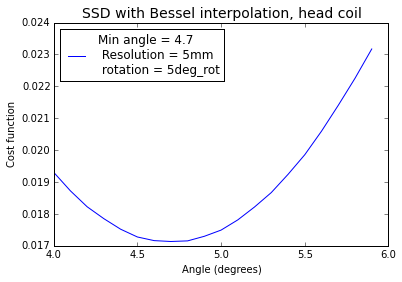

In [84]:
# head coil Bessel interpolation with R=all
thetas = np.arange(4,6,0.1)
cost_5deg_LR = bessel_cost_func(head_iso_5mm, head_5deg_LR_5mm, thetas, axis=0)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2


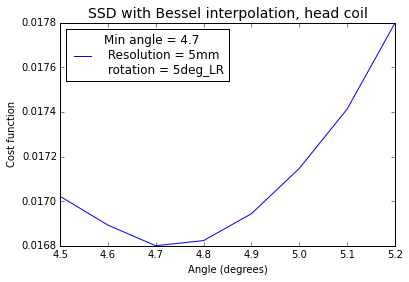

In [207]:
# head coil Bessel interpolation with R=8
thetas = np.arange(4.5,5.3,0.1)
cost_5deg_LR = bessel_cost_func(head_iso_5mm, head_5deg_LR_5mm, thetas, axis=0,mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'head')

 4.0 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9


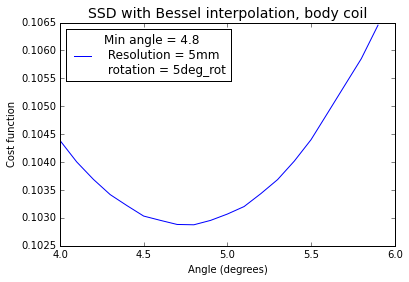

In [124]:
# body coil Bessel interpolation with R=all
thetas = np.arange(4,6,0.1)
cost_5deg_LR = bessel_cost_func(body_iso_5mm, body_5deg_LR_5mm, thetas, axis=0, mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')

4.5 4.6 4.7 4.8 4.9 5.0 5.1 5.2


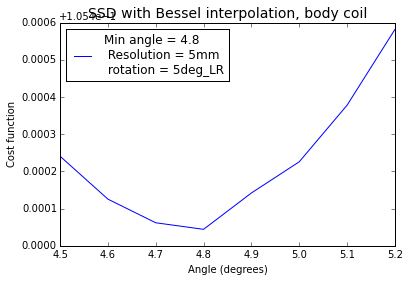

In [165]:
# body coil Bessel interpolation with R=8
thetas = np.arange(4.5,5.3,0.1)
cost_5deg_LR = bessel_cost_func(body_iso_5mm, body_5deg_LR_5mm, thetas, axis=0, mask = True)
plot_cost_func(thetas, cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')

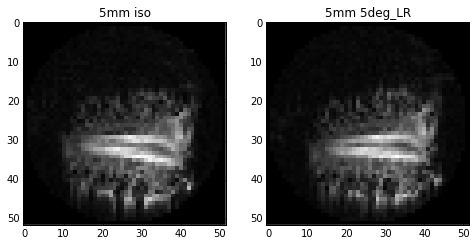

In [183]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.imshow(circle_mask(head_iso_5mm[26,:,:]), interpolation= 'None',cmap='gray')
plt.title('5mm iso')
plt.subplot(1,2,2)
plt.imshow(circle_mask(head_5deg_LR_5mm[26,:,:]), interpolation= 'None',cmap='gray')
plt.title('5mm 5deg_LR')
plt.show()

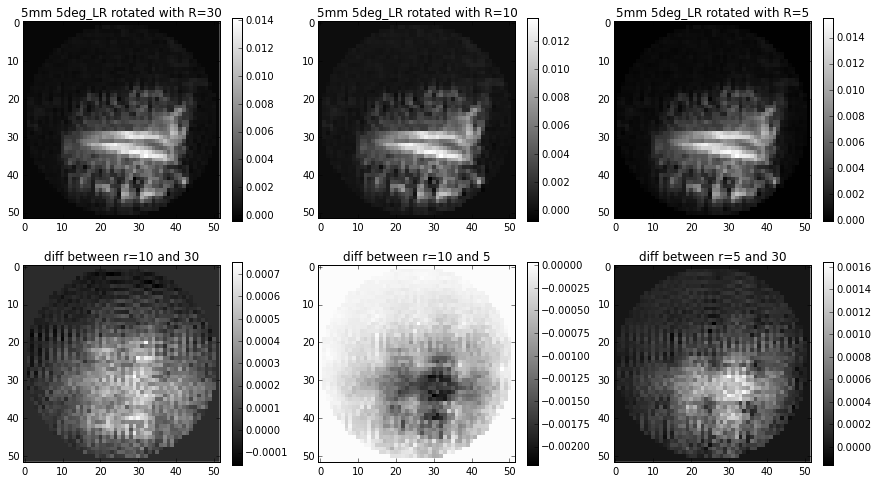

In [181]:
result_30 = bessel_rotate(head_5deg_LR_5mm[26,:,:],5,mask=True,r=30)
result_10 = bessel_rotate(head_5deg_LR_5mm[26,:,:],5,mask=True,r=10)
result_5 = bessel_rotate(head_5deg_LR_5mm[26,:,:],5,mask=True,r=5)
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.imshow(result_30, interpolation= 'None',cmap='gray')
plt.title('5mm 5deg_LR rotated with R=30')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(result_10, interpolation= 'None',cmap='gray')
plt.title('5mm 5deg_LR rotated with R=10')
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(result_5, interpolation= 'None',cmap='gray')
plt.title('5mm 5deg_LR rotated with R=5')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(result_30-result_10, interpolation= 'None',cmap='gray')
plt.title('diff between r=10 and 30')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(result_10-result_5, interpolation= 'None',cmap='gray')
plt.title('diff between r=10 and 5')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(result_5-result_30, interpolation= 'None',cmap='gray')
plt.title('diff between r=5 and 30')
plt.colorbar()
plt.show()

In [187]:
N = 100
sequencer = ghalton.GeneralizedHalton(ghalton.EA_PERMS[:3])
sequencer.reset()
points = sequencer.get(N)
pts = np.array(points)
s = (len(head_iso_5mm)-1)/2.
x1 = (len(head_iso_5mm)-1) * pts[:,0] - s
y1 = (len(head_iso_5mm)-1) * pts[:,1] - s

mask = np.sqrt(x1**2+y1**2) < s
plt.figure(figsize=[5,5])
plt.scatter(x1[mask],y1[mask])
plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

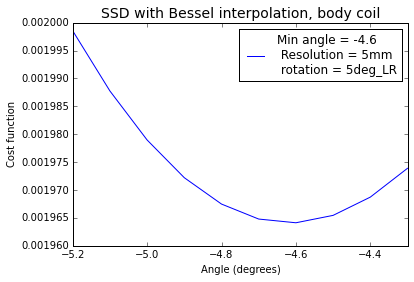

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

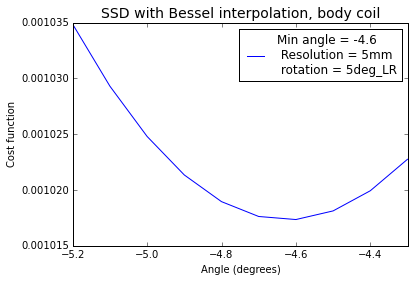

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

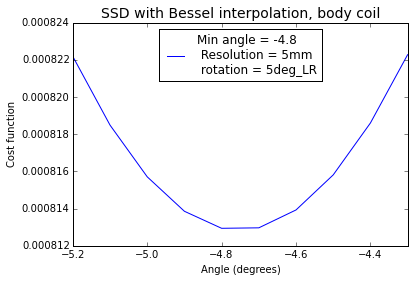

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

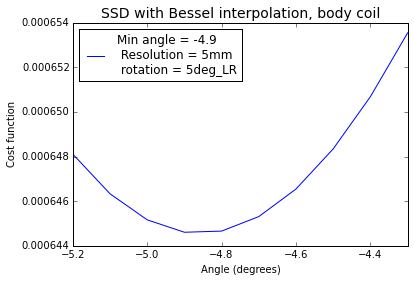

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

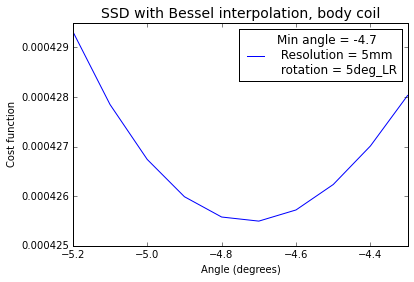

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

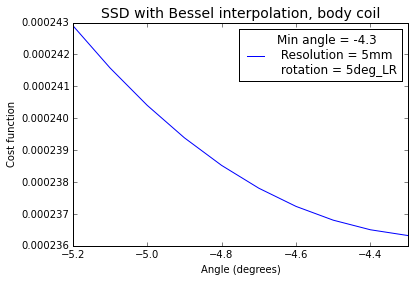

In [258]:
thetas = np.arange(-5.2,-4.3,0.1)
N = 100
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 50
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 40
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 30
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 20
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 10
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()

73 -4.9 -4.89 -4.88 -4.87 -4.86 -4.85 -4.84 -4.83 -4.82 -4.81 -4.8 -4.79 -4.78 -4.77 -4.76 -4.75 -4.74 -4.73 -4.72 -4.71 -4.7 -4.69 -4.68 -4.67 -4.66 -4.65 -4.64 -4.63 -4.62 -4.61 -4.6

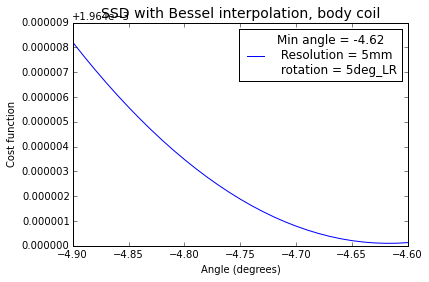

In [267]:
thetas = np.arange(-4.9,-4.6,0.01)
N = 100
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_5mm, body_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()

73 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

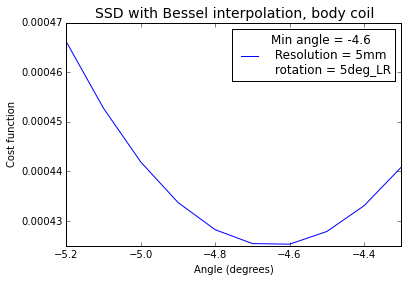

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

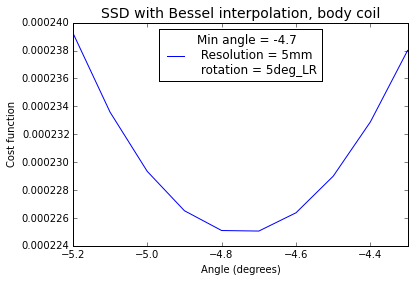

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

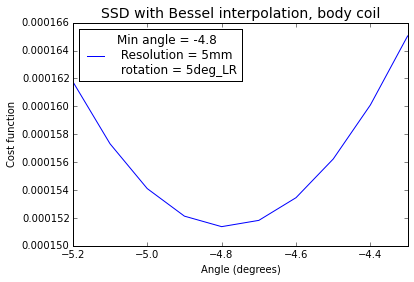

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

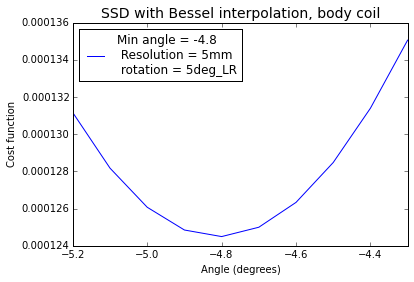

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

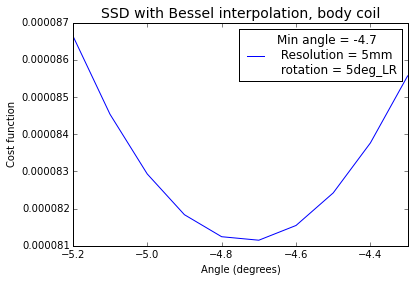

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

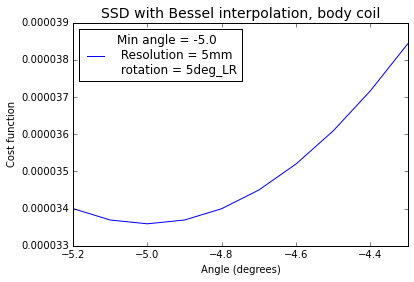

In [257]:
thetas = np.arange(-5.2,-4.3,0.1)
N = 100
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 50
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 40
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 30
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 20
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 10
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()

723 -5.1 -5.09 -5.08 -5.07 -5.06 -5.05 -5.04 -5.03 -5.02 -5.01 -5.0 -4.99 -4.98 -4.97 -4.96 -4.95 -4.94 -4.93 -4.92 -4.91

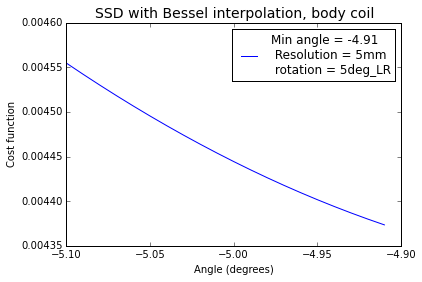

In [265]:
thetas = np.arange(-5.1,-4.9,0.01)
N = 1000
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_5mm, head_5deg_LR_5mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '5mm', 'Bessel','5deg_LR', 'body')
plt.show()

In [259]:
# get some more test data
# head coil
head_iso_8mm = data_dict['8mm']['head']['iso'][0]
head_5deg_LR_8mm = data_dict['8mm']['head']['LR']['5deg'][0]
head_5deg_AP_8mm = data_dict['8mm']['head']['AP']['5deg'][0]
# body coil
body_iso_8mm = data_dict['8mm']['body']['iso'][0]
body_5deg_LR_8mm = data_dict['8mm']['body']['LR']['5deg'][0]
body_5deg_AP_8mm = data_dict['8mm']['body']['AP']['5deg'][0]

71 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

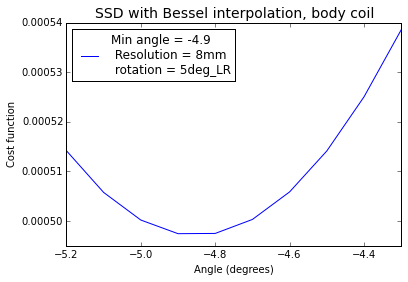

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

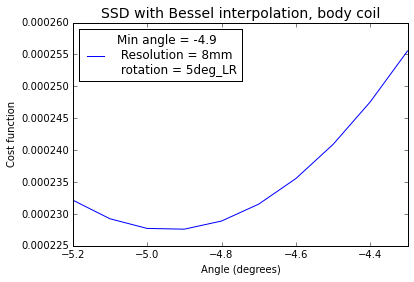

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

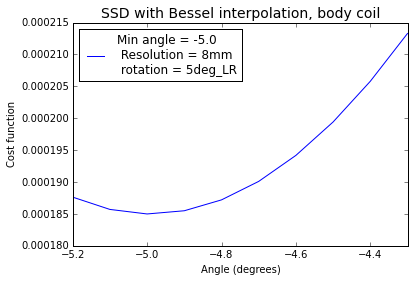

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

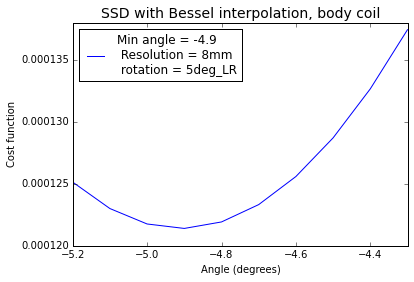

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

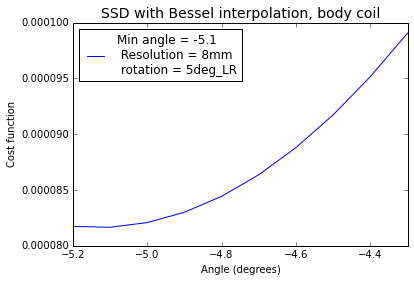

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

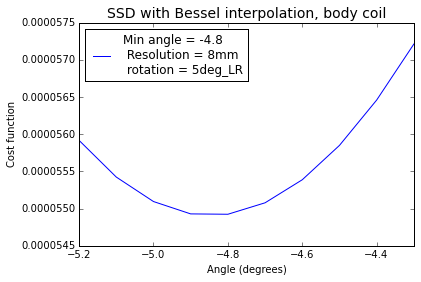

In [262]:
thetas = np.arange(-5.2,-4.3,0.1)
N = 100
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 50
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 40
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 30
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 20
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 10
halton_cost_5deg_LR = bessel_halton_cost_func_circle(head_iso_8mm, head_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()

71 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

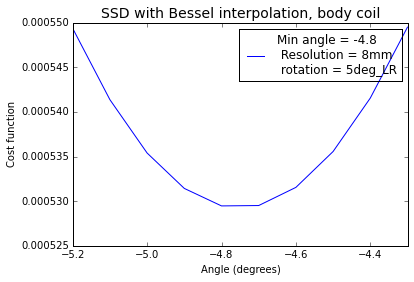

 36 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

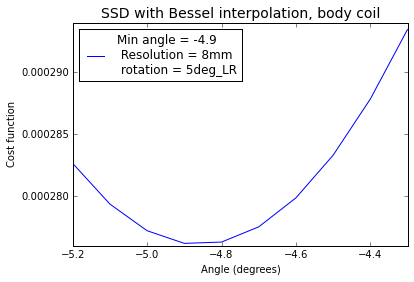

 29 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

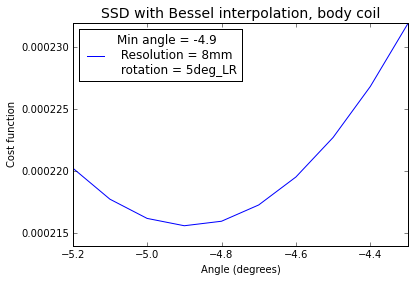

 23 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

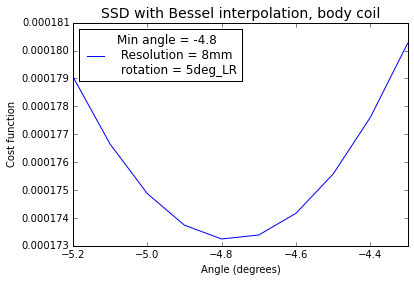

 15 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

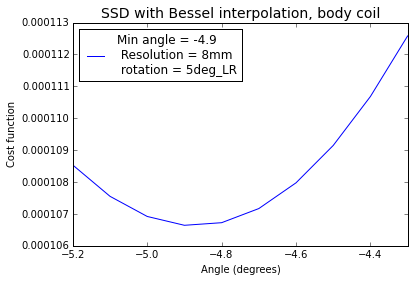

 9 -5.2 -5.1 -5.0 -4.9 -4.8 -4.7 -4.6 -4.5 -4.4 -4.3

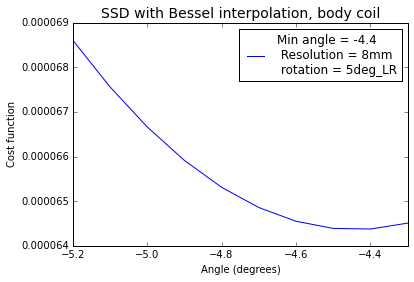

In [261]:
thetas = np.arange(-5.2,-4.3,0.1)
N = 100
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 50
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 40
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 30
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 20
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()
N = 10
halton_cost_5deg_LR = bessel_halton_cost_func_circle(body_iso_8mm, body_5deg_LR_8mm, N, thetas, axis=0)
plot_cost_func(thetas, halton_cost_5deg_LR, '8mm', 'Bessel','5deg_LR', 'body')
plt.show()

## Linear Interpolation

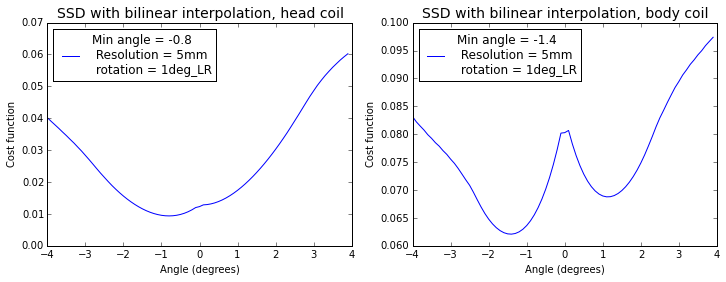

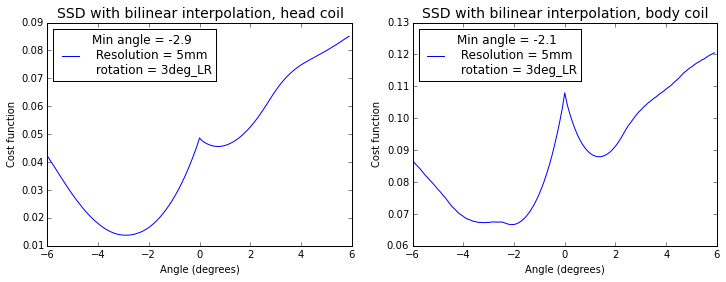

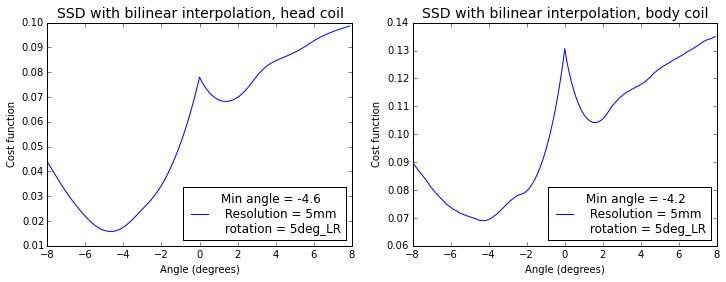

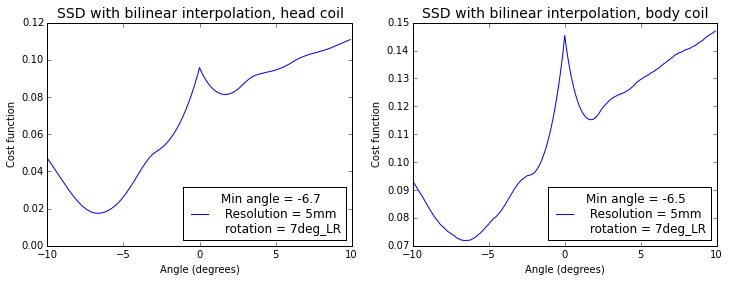

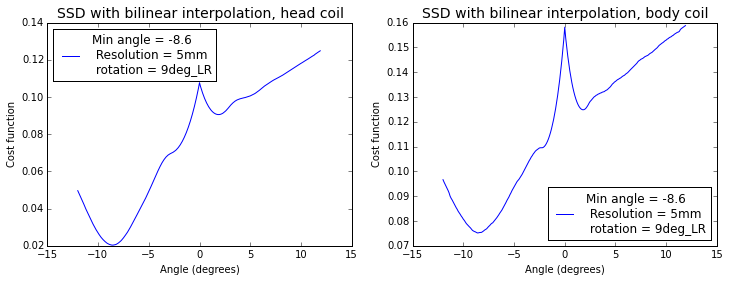

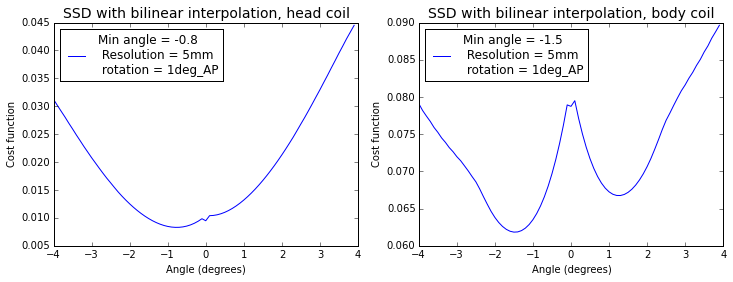

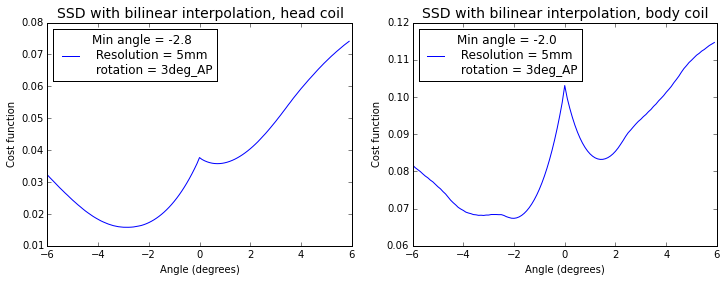

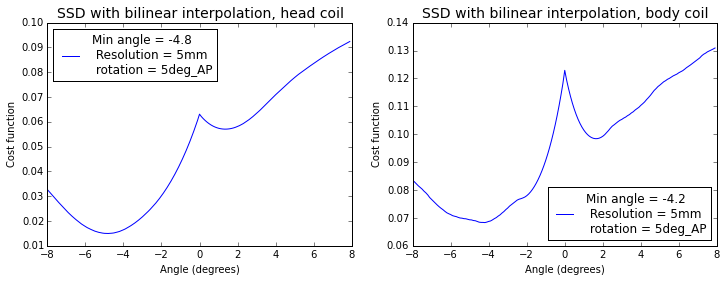

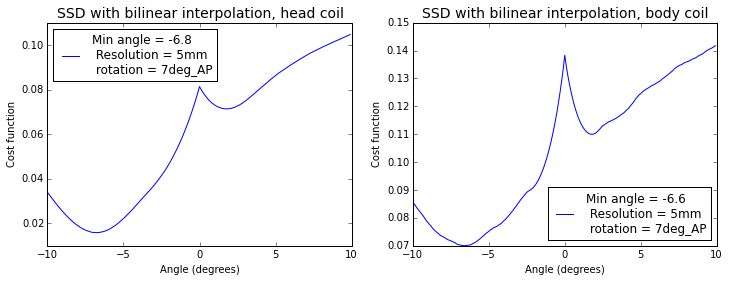

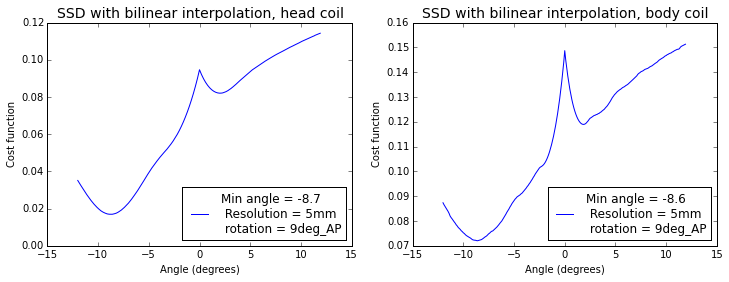

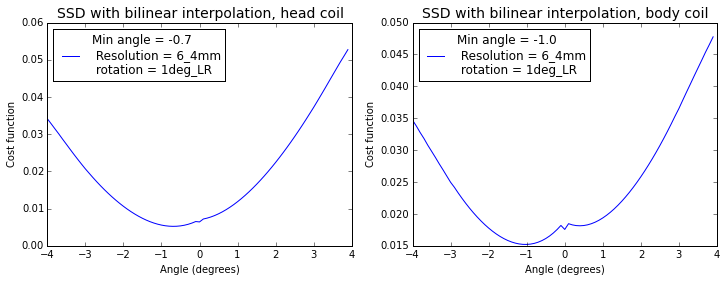

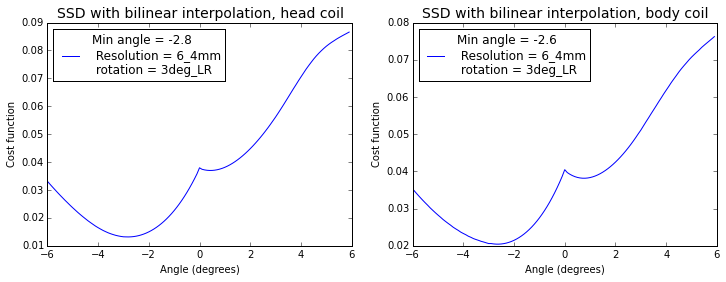

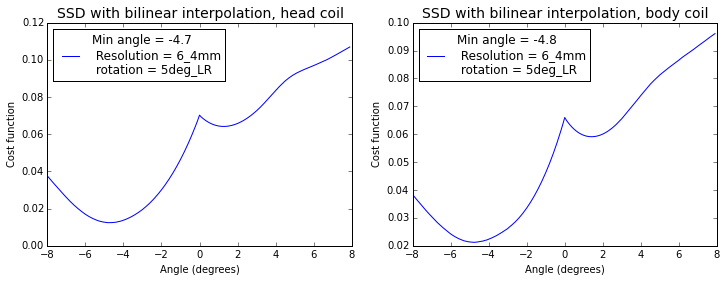

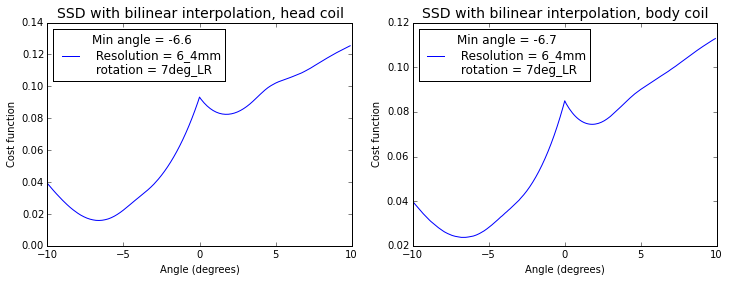

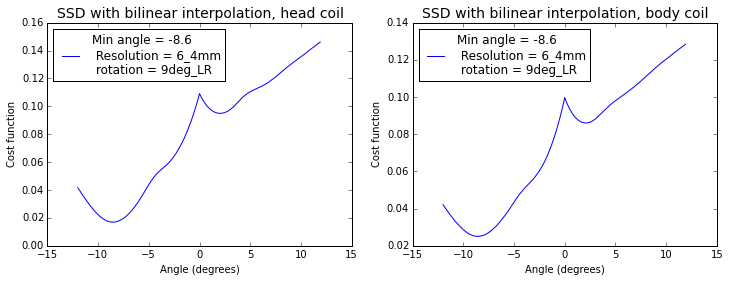

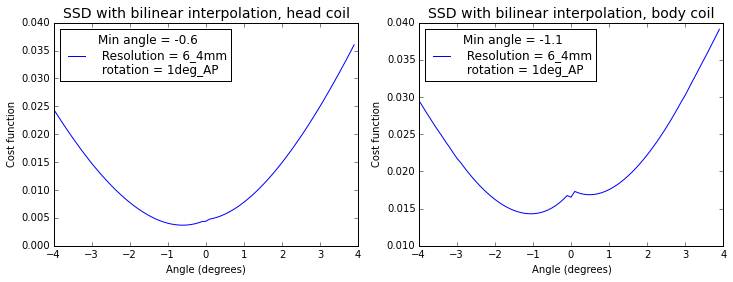

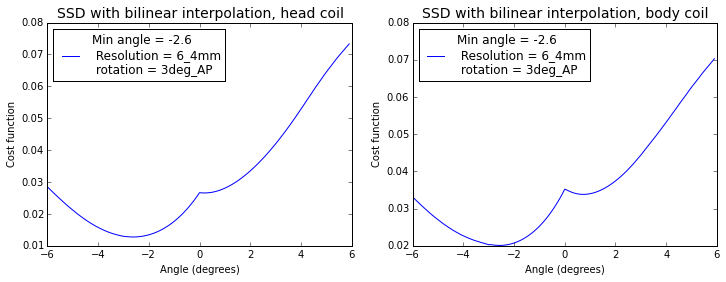

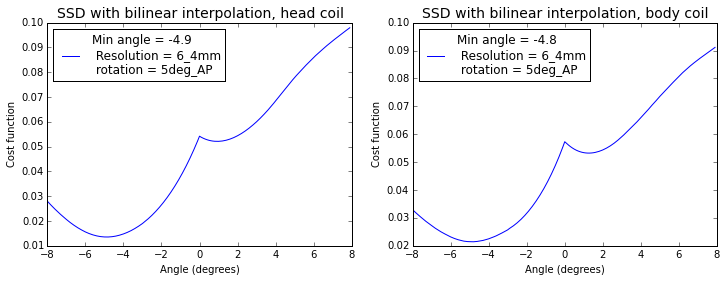

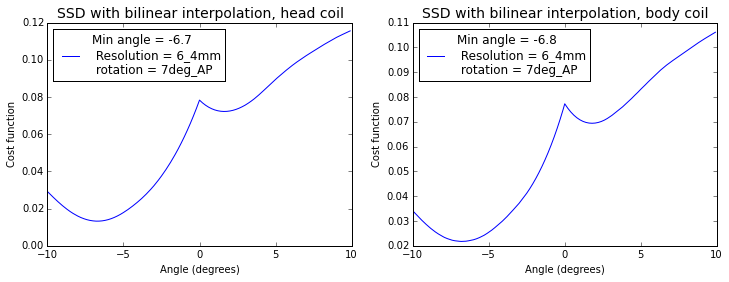

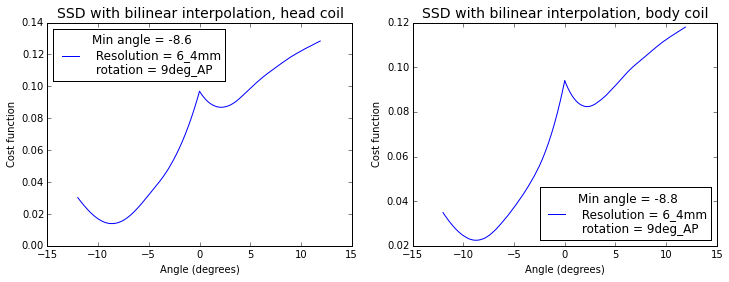

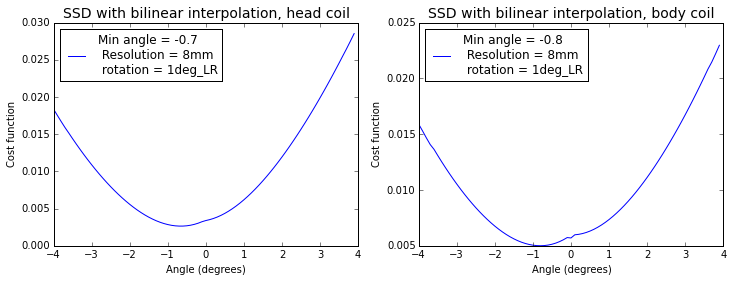

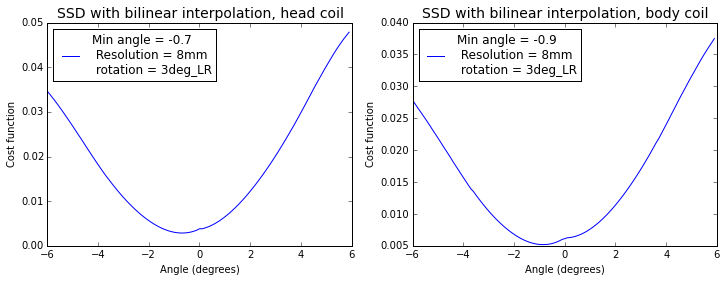

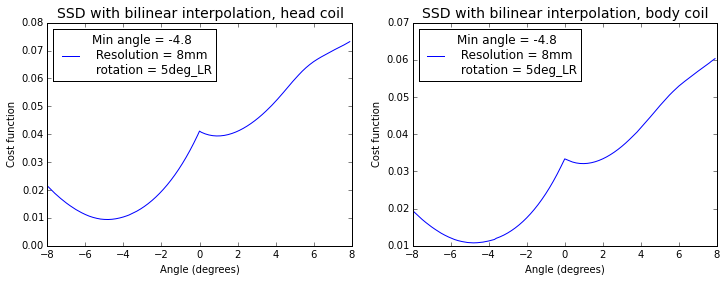

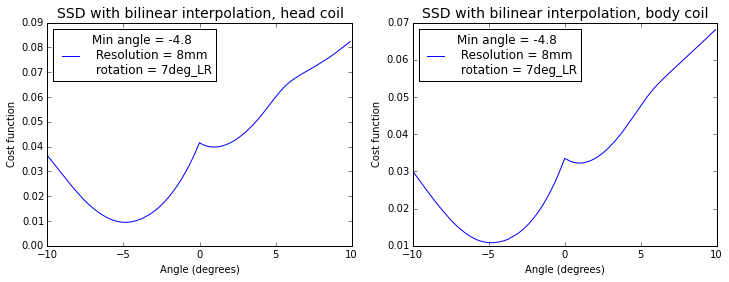

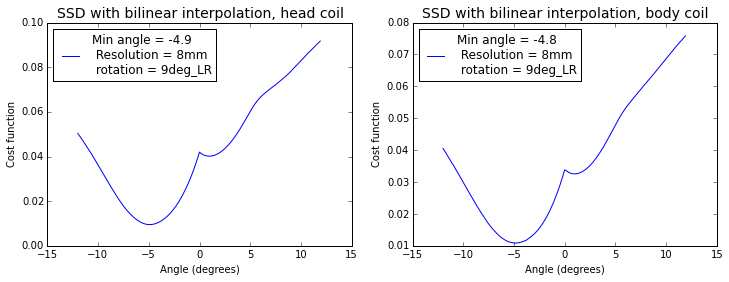

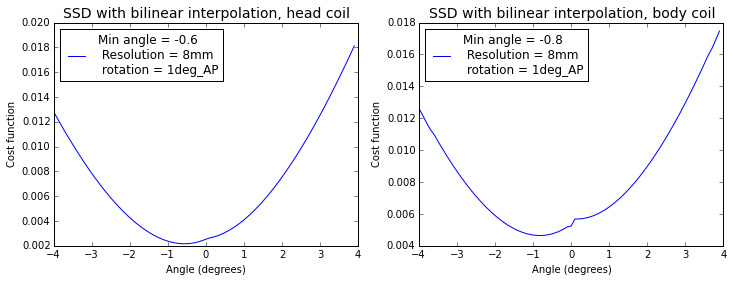

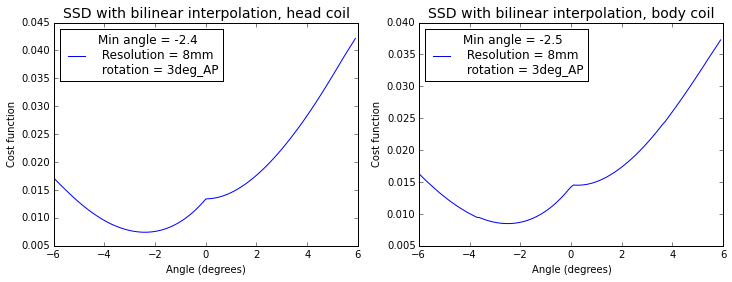

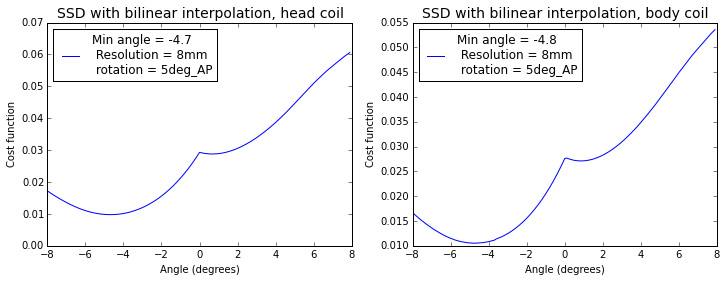

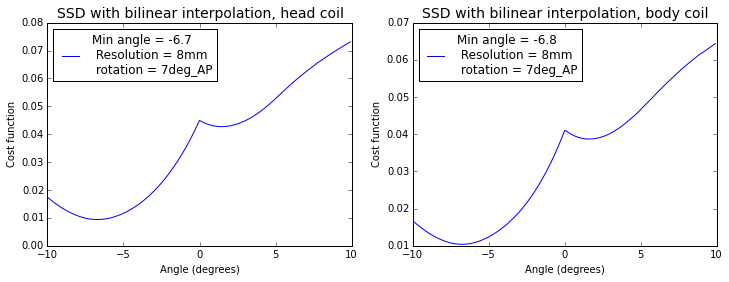

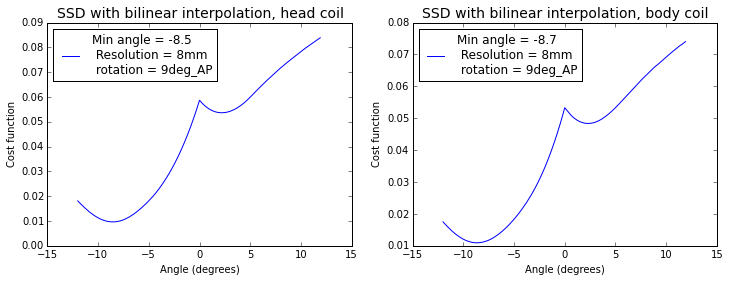

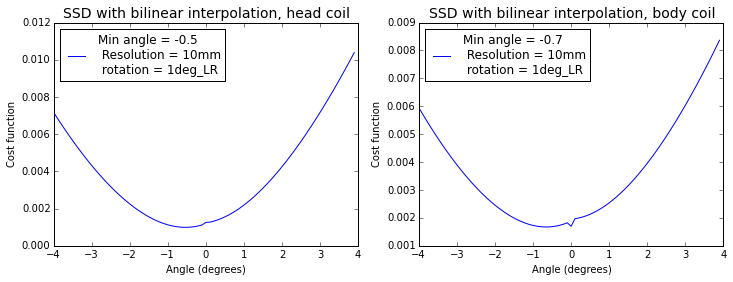

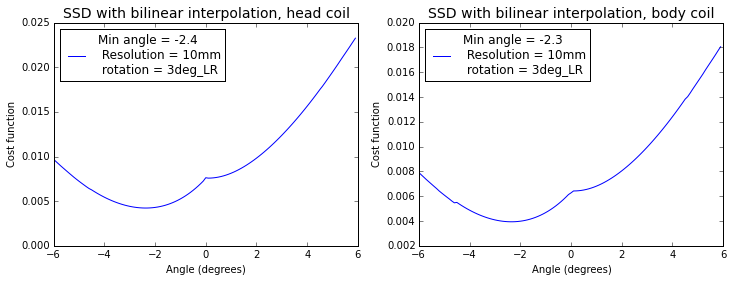

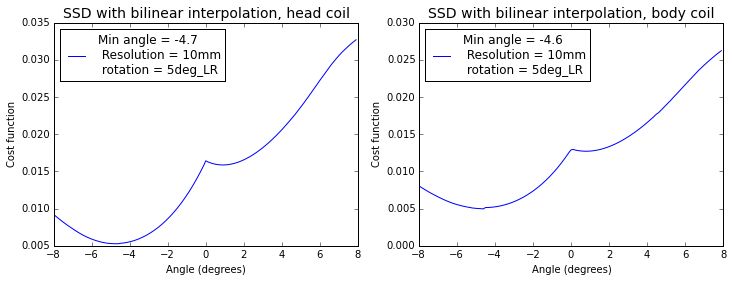

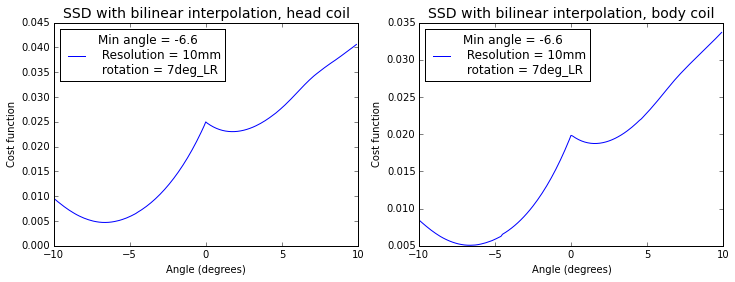

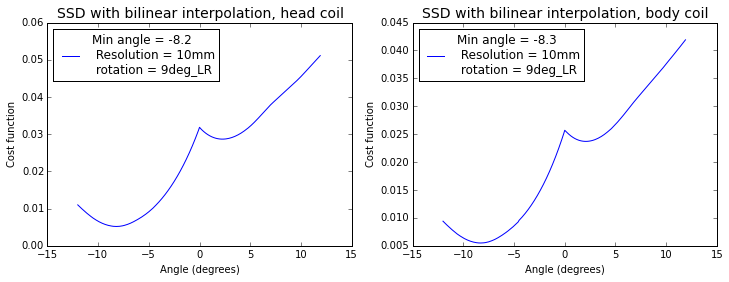

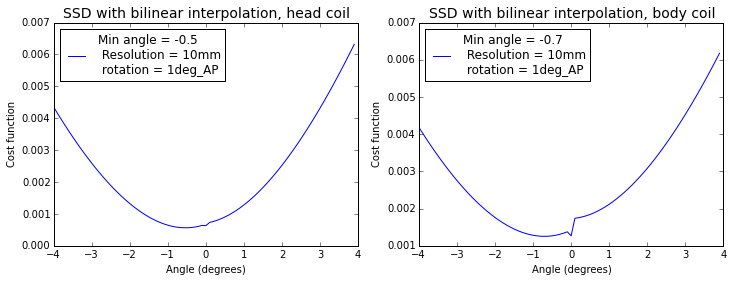

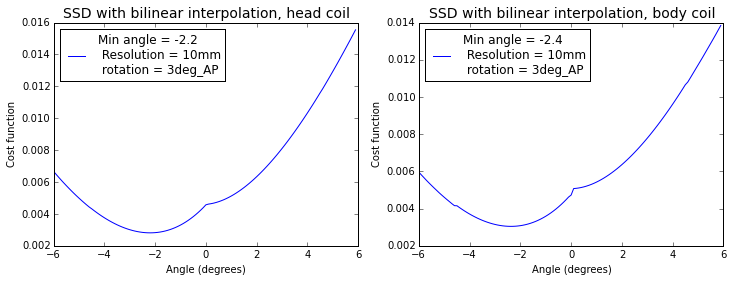

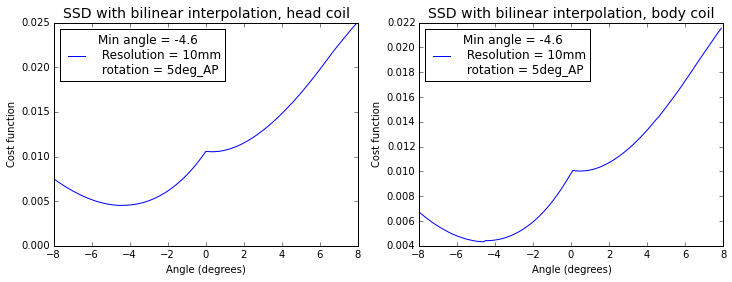

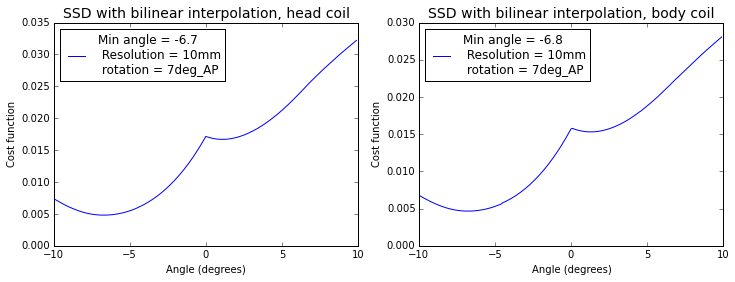

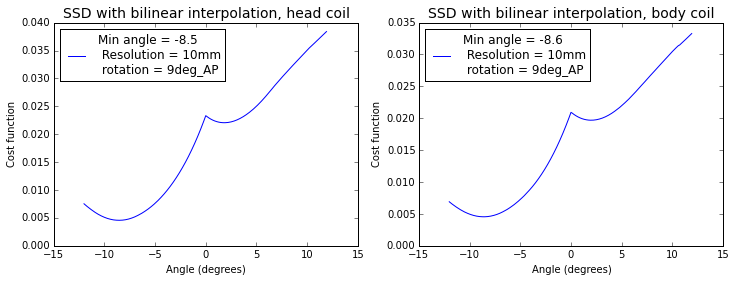

In [55]:
# repetition 0
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][0],data_dict[res][coil][rot][deg][0],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

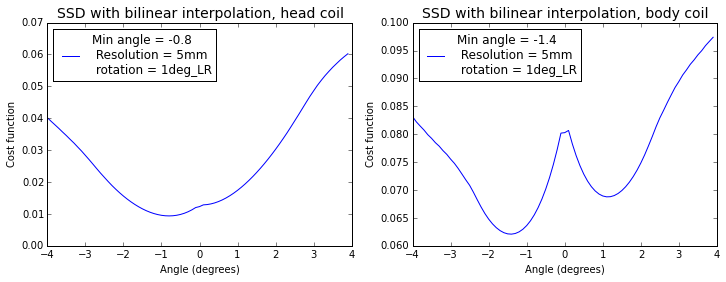

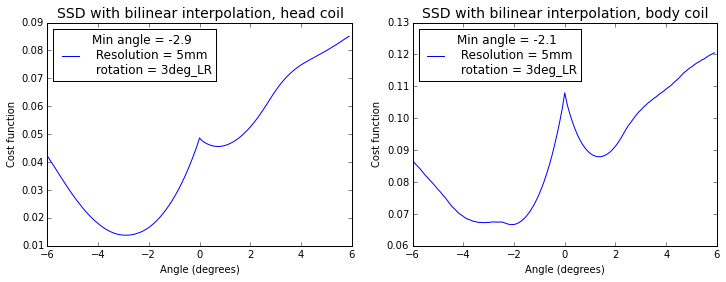

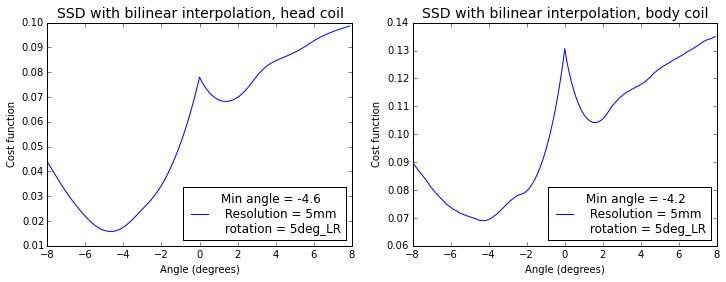

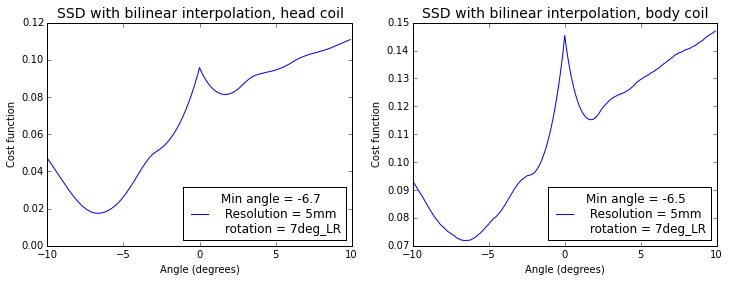

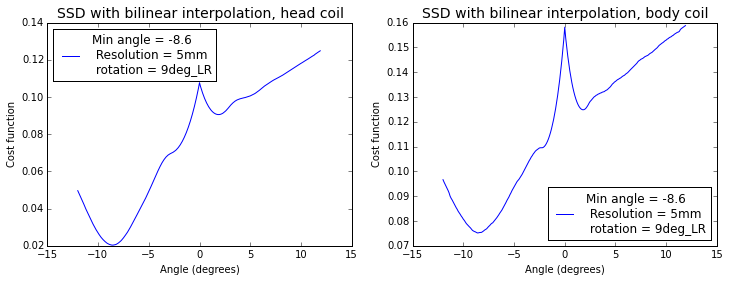

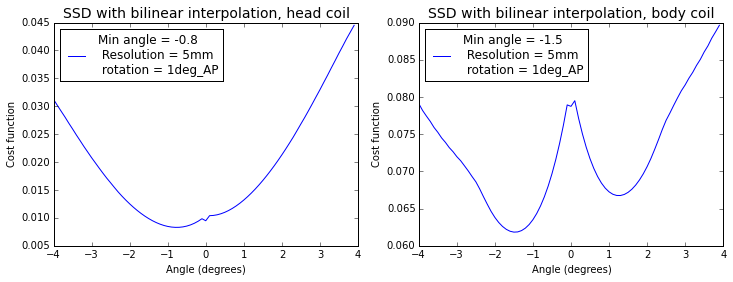

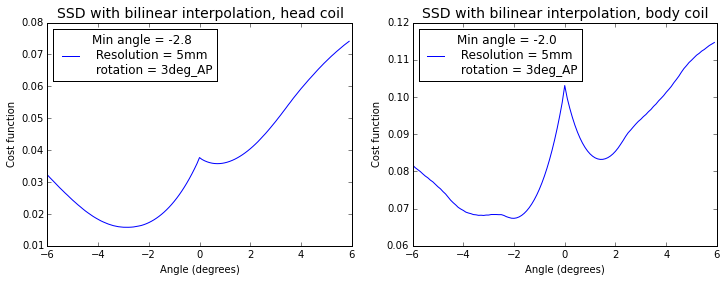

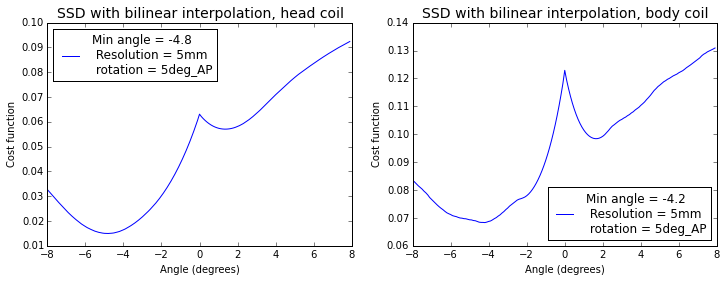

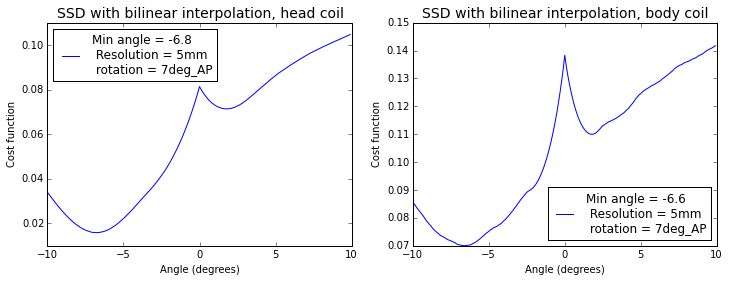

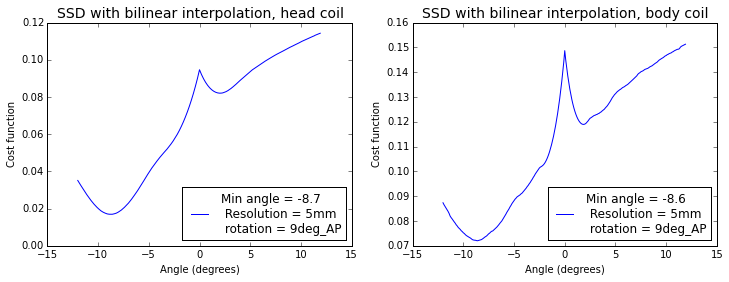

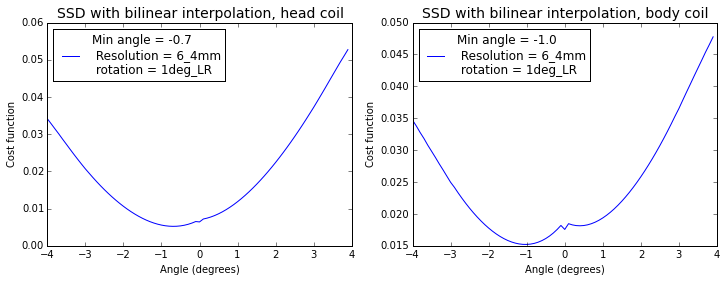

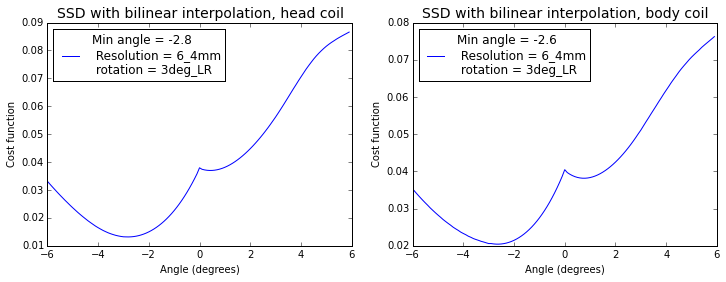

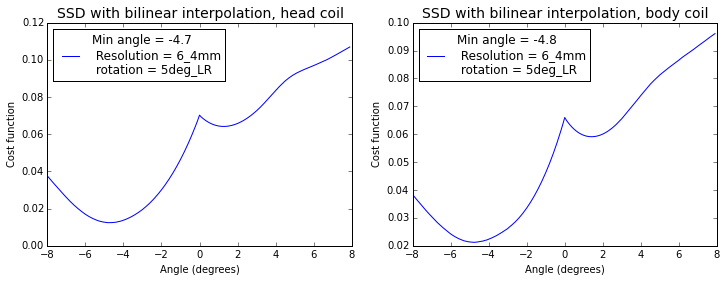

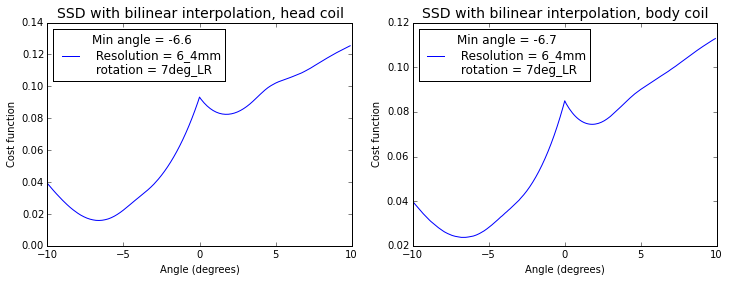

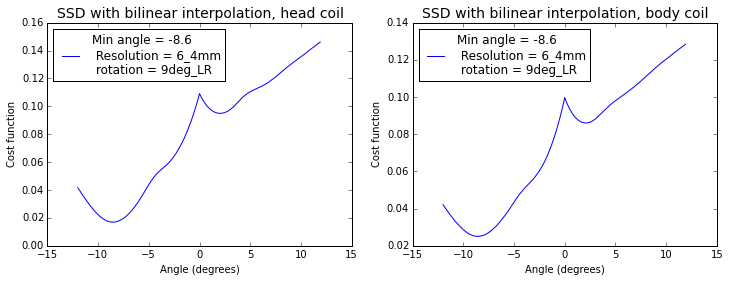

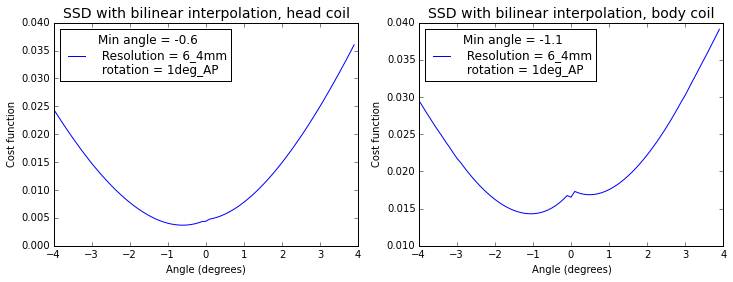

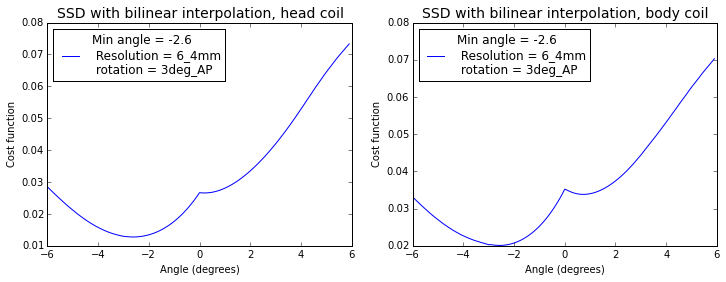

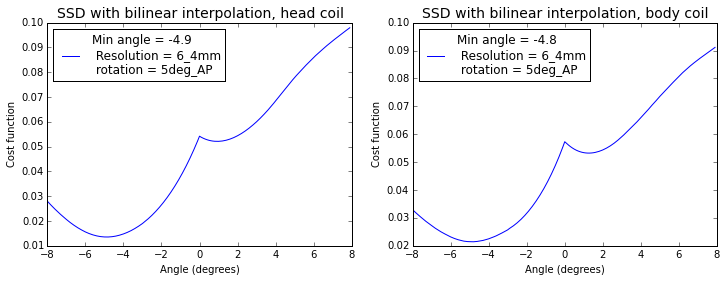

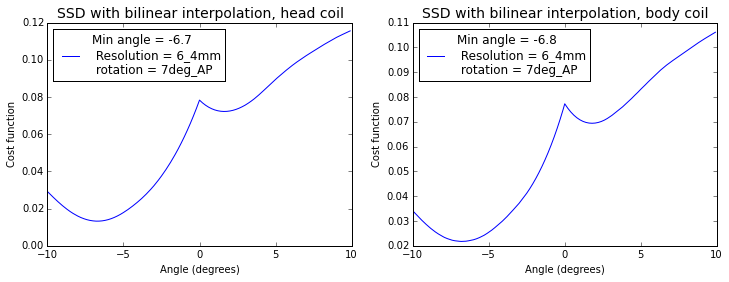

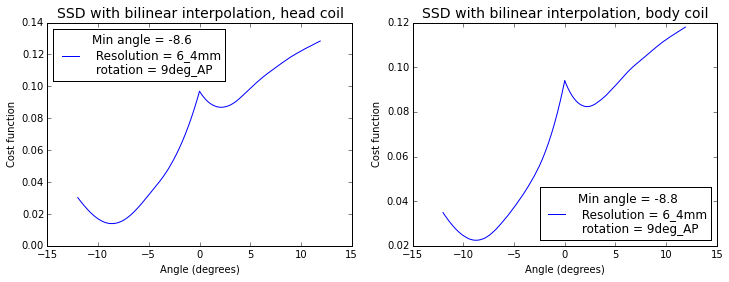

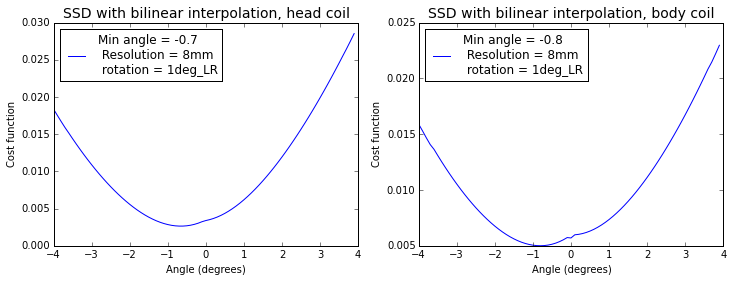

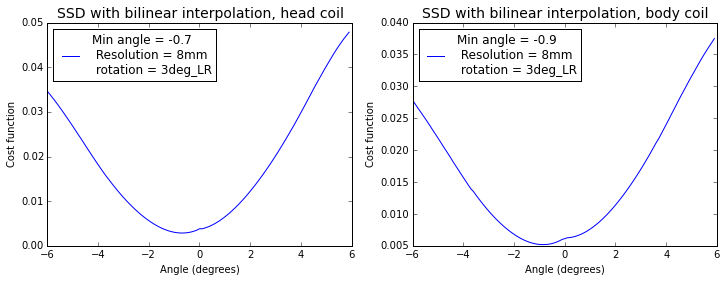

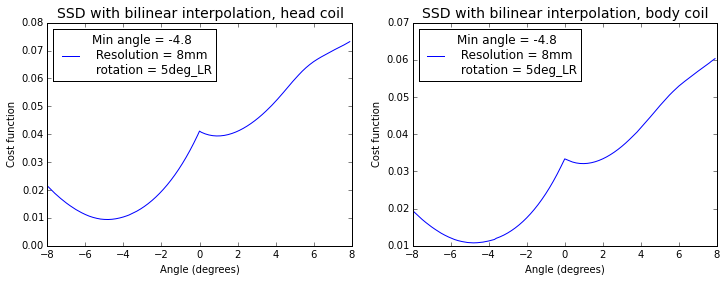

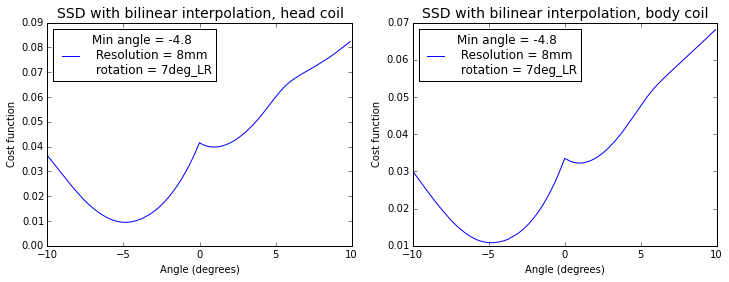

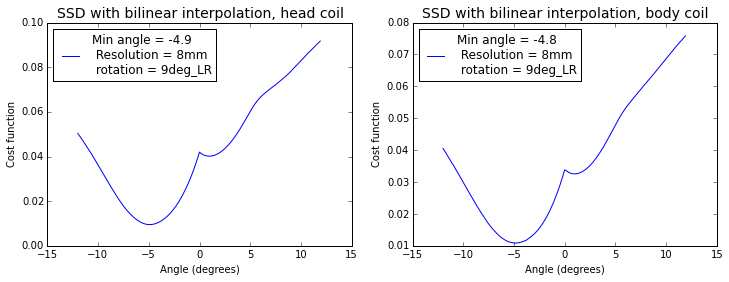

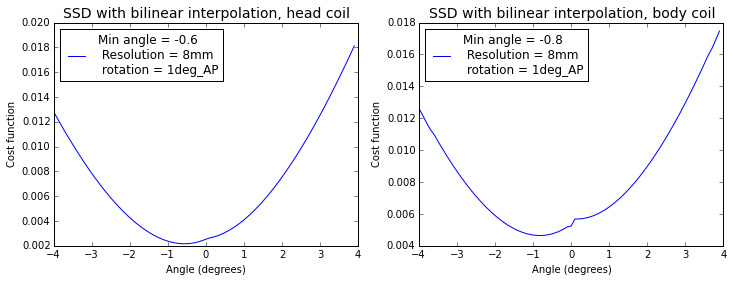

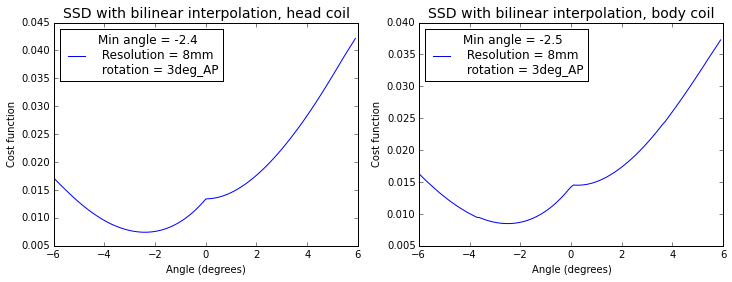

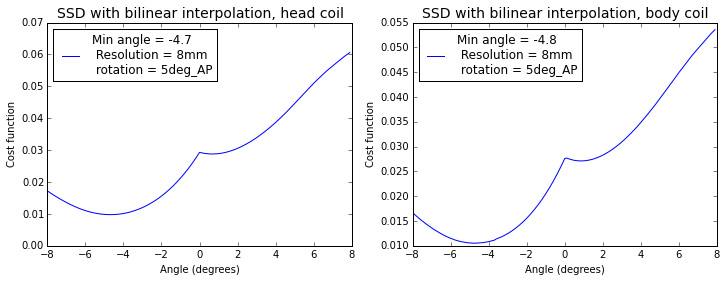

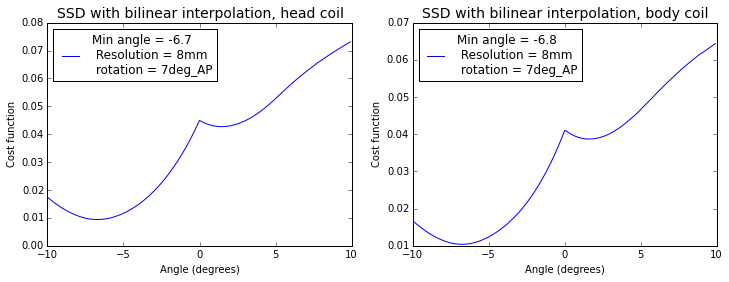

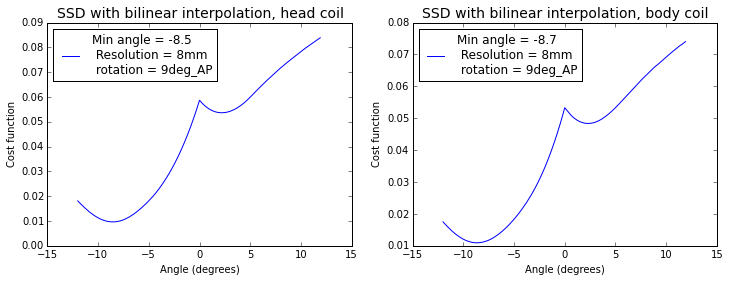

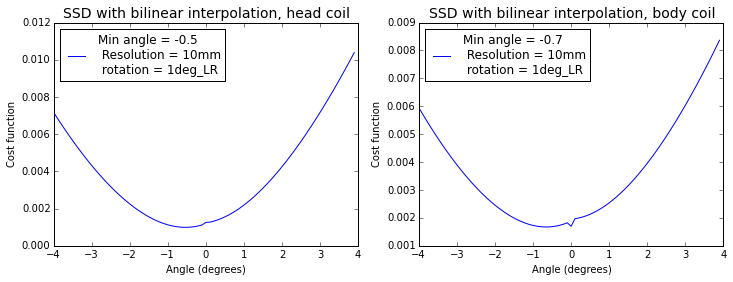

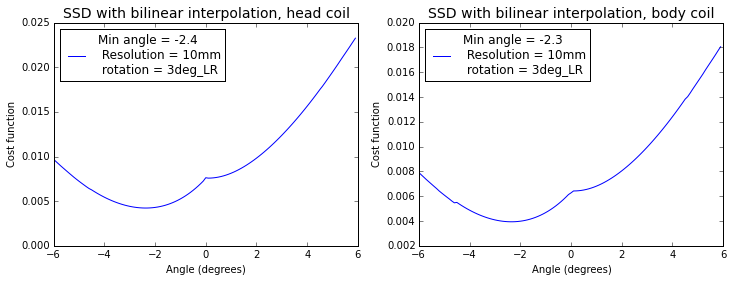

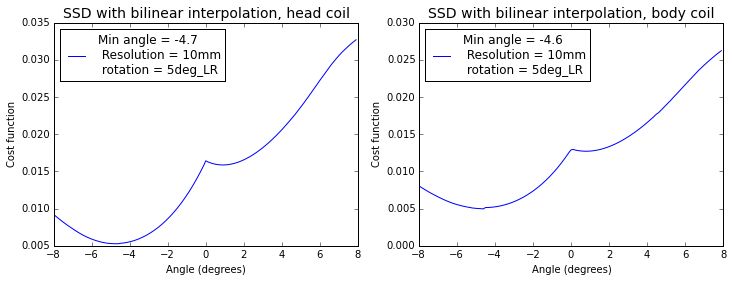

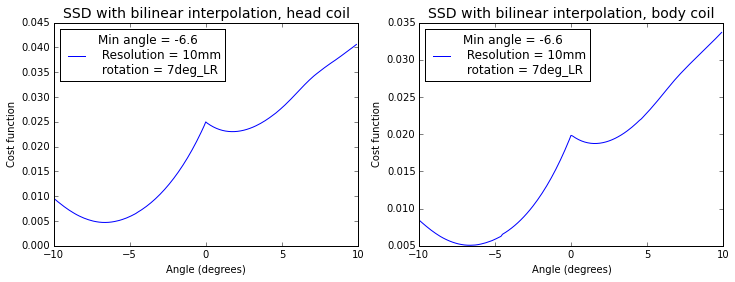

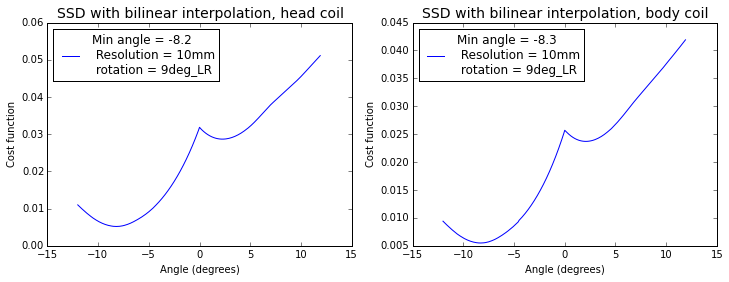

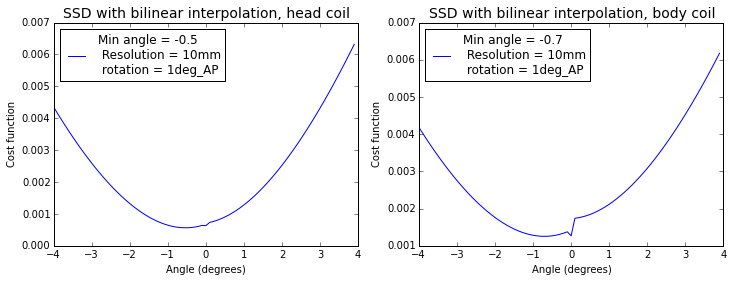

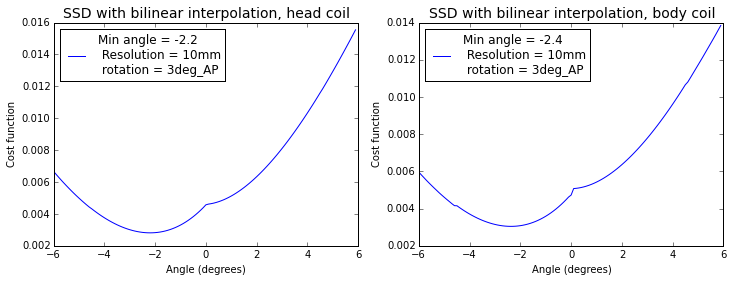

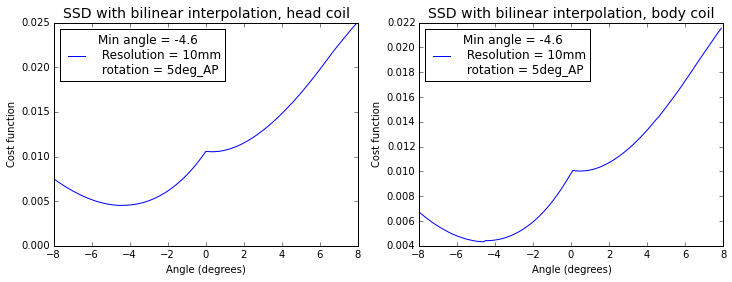

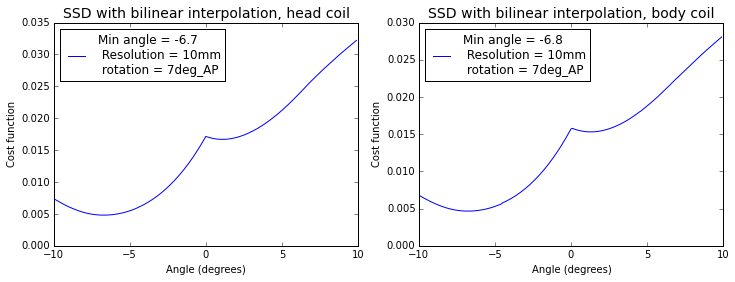

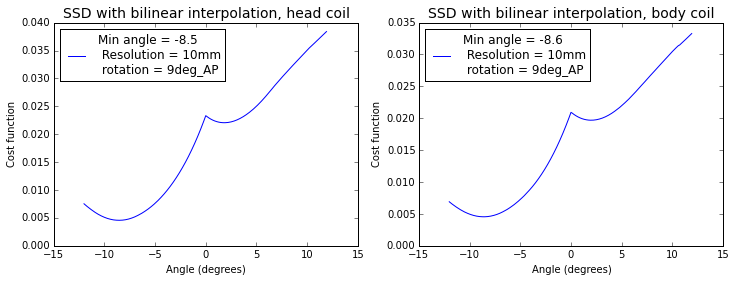

In [56]:
# repetition 1
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][1],data_dict[res][coil][rot][deg][1],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()

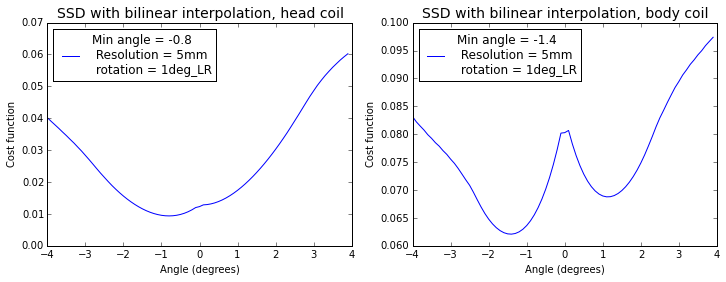

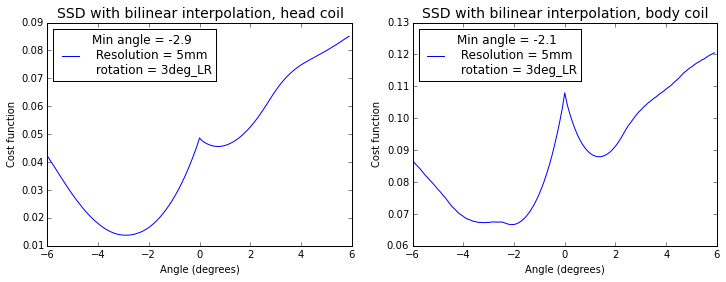

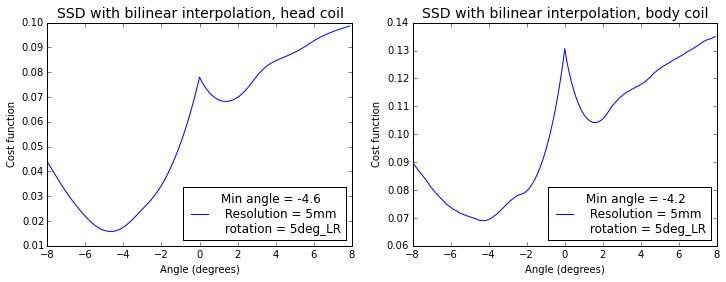

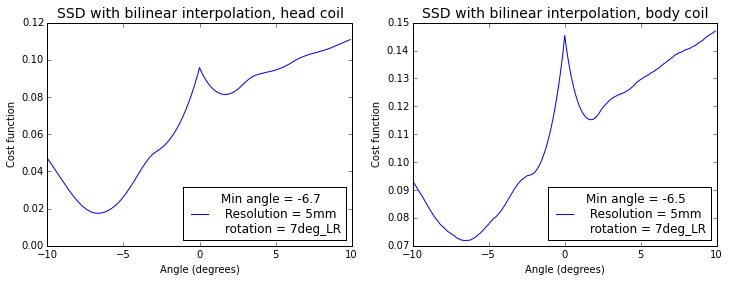

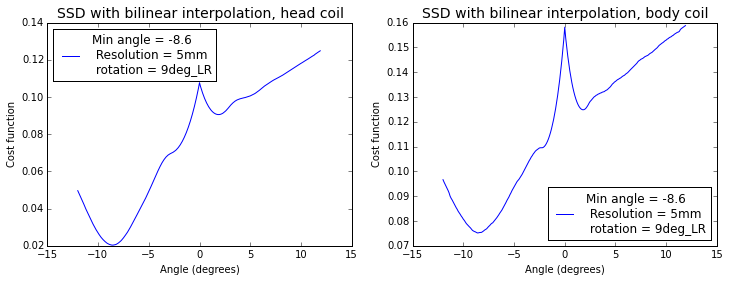

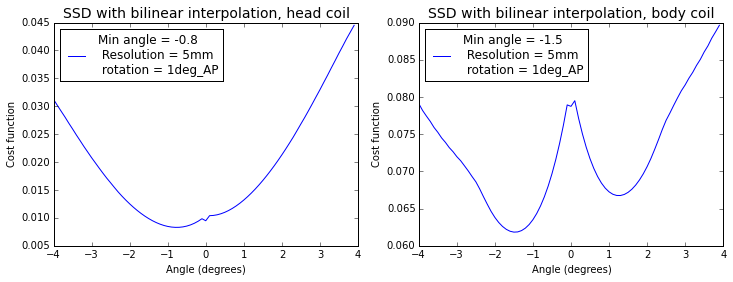

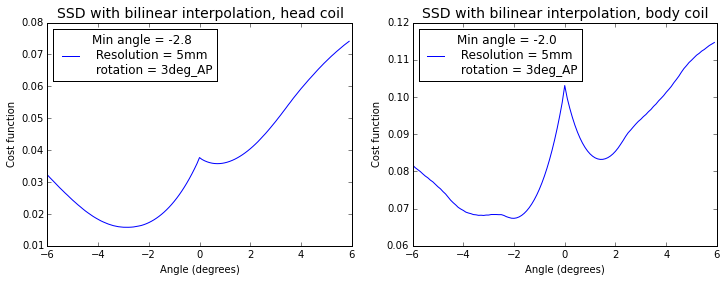

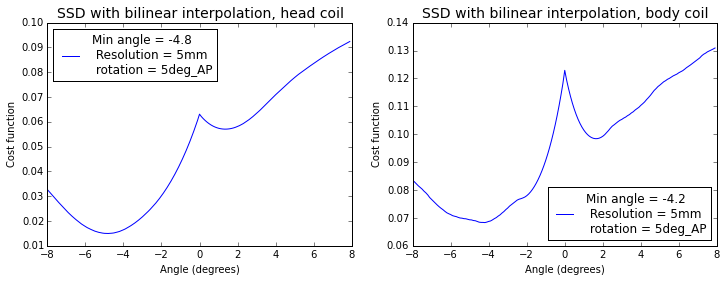

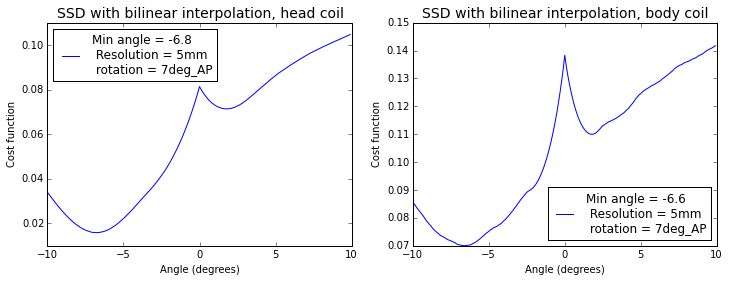

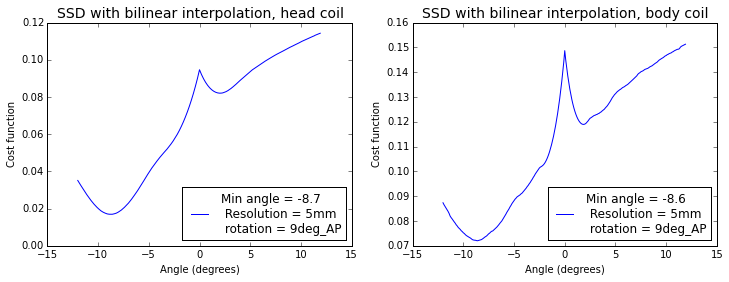

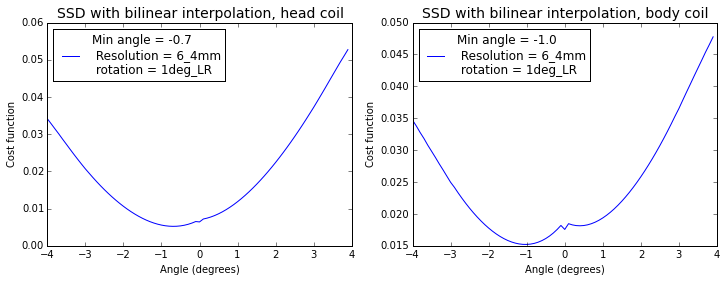

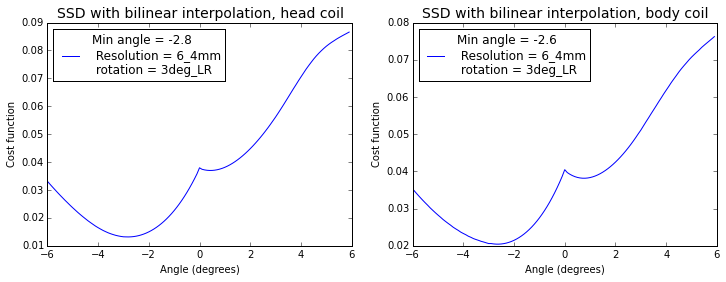

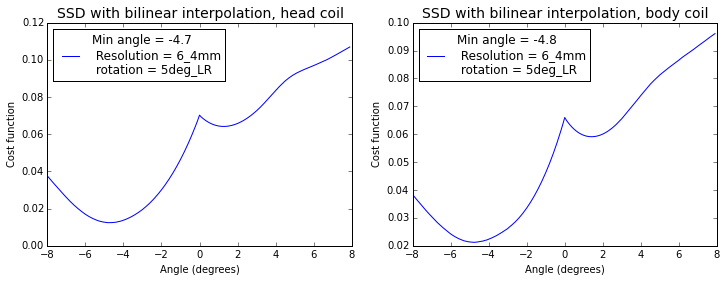

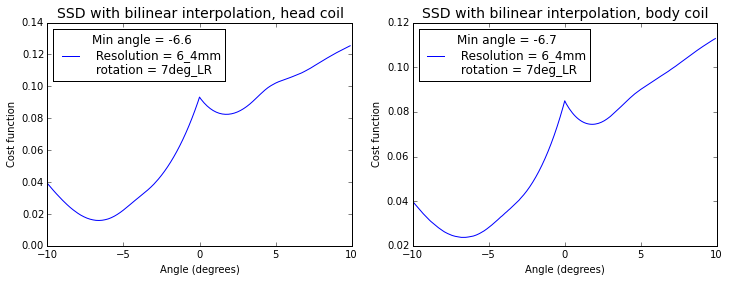

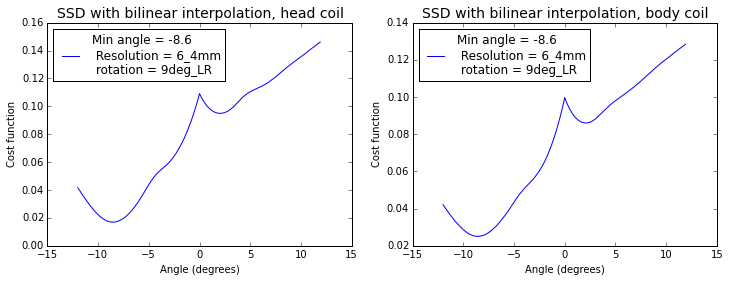

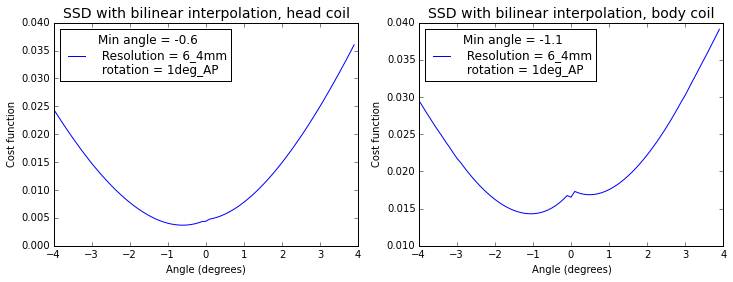

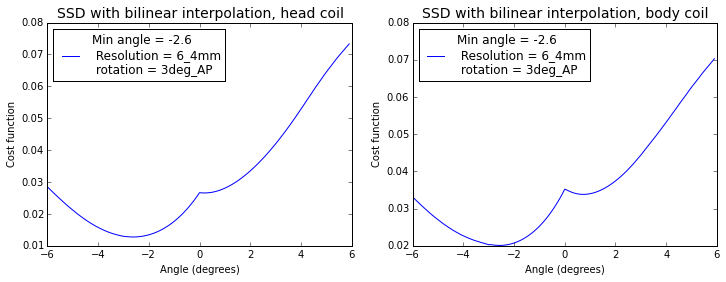

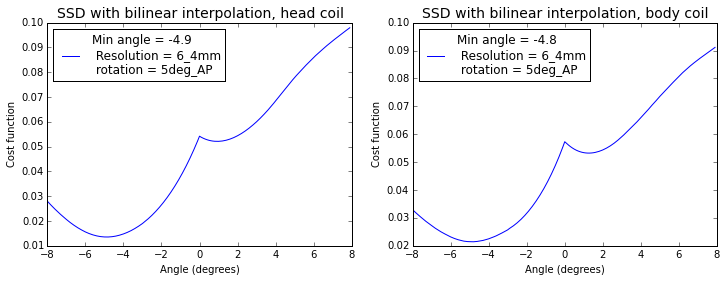

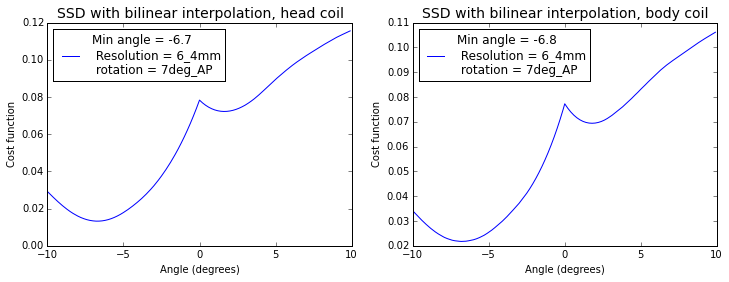

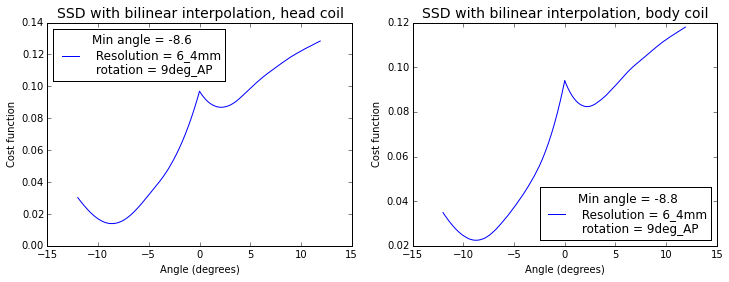

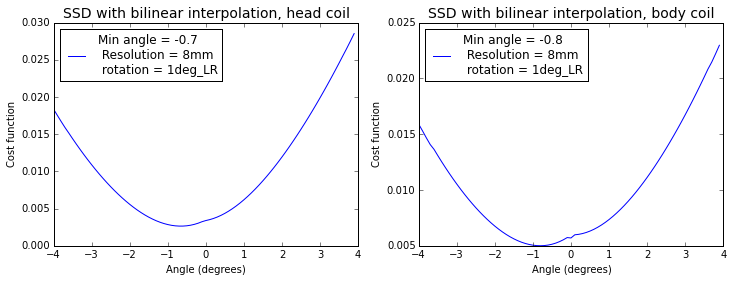

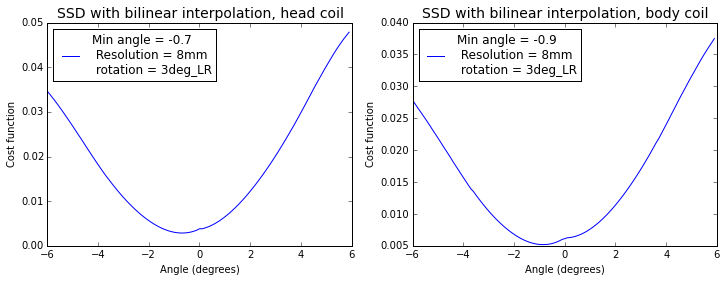

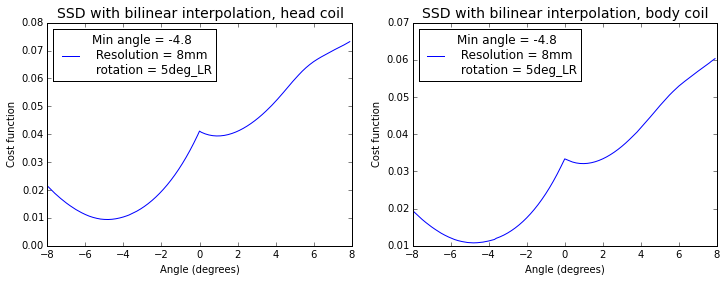

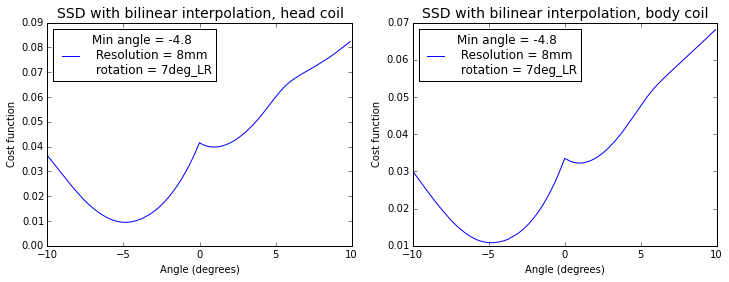

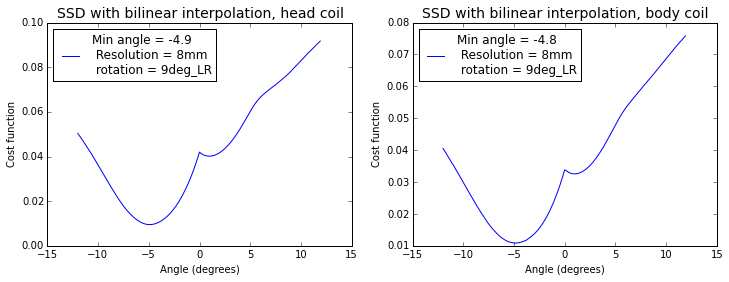

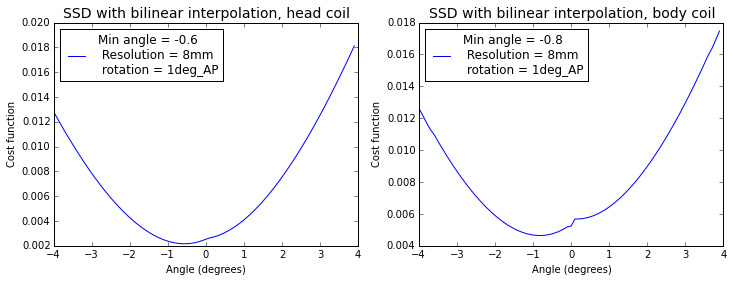

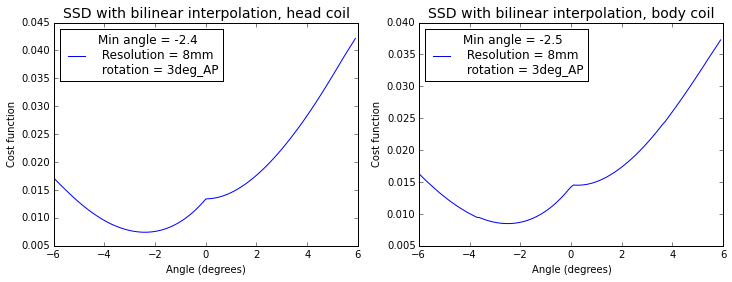

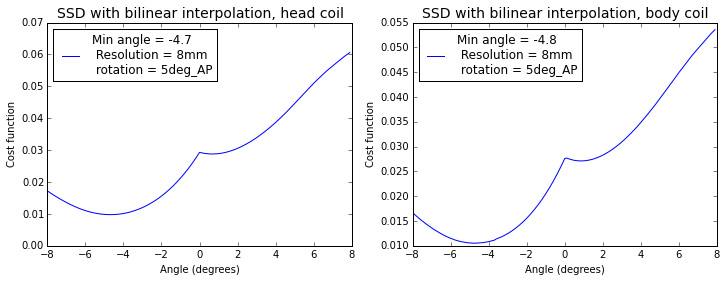

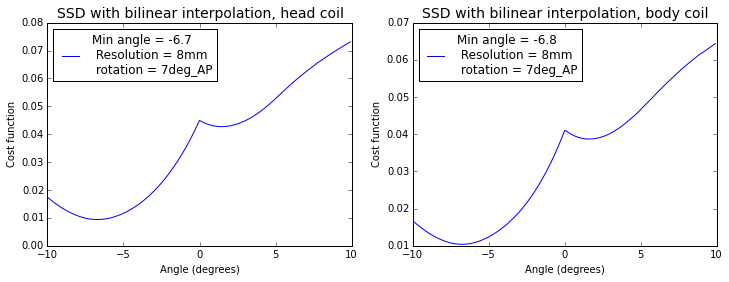

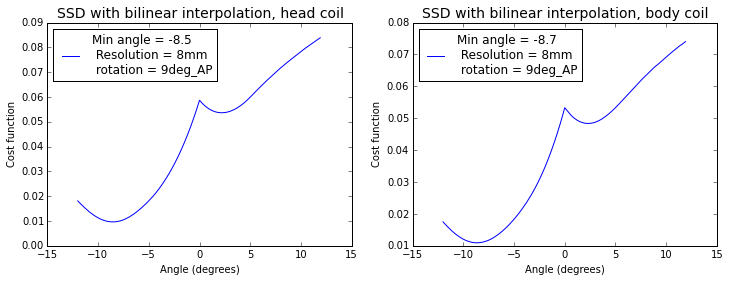

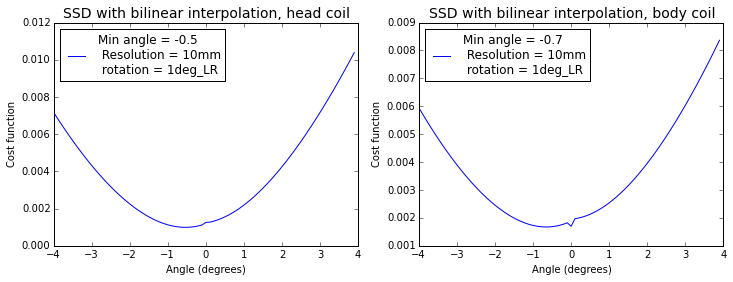

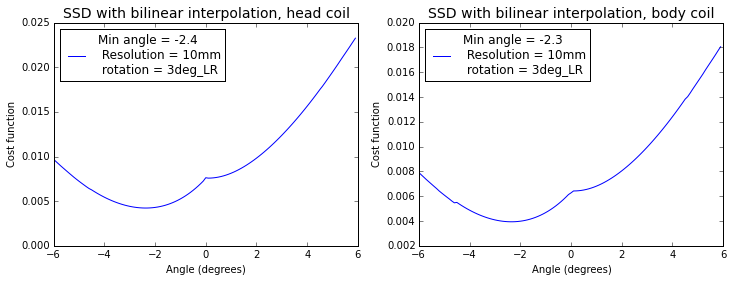

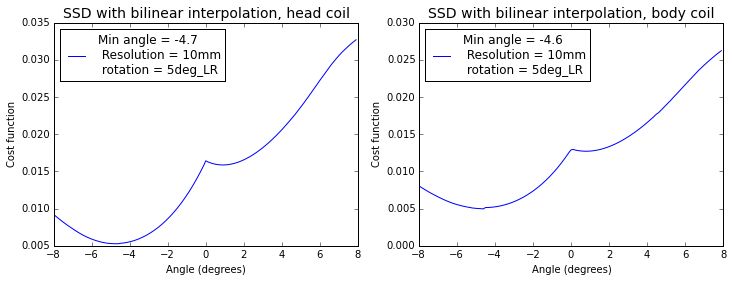

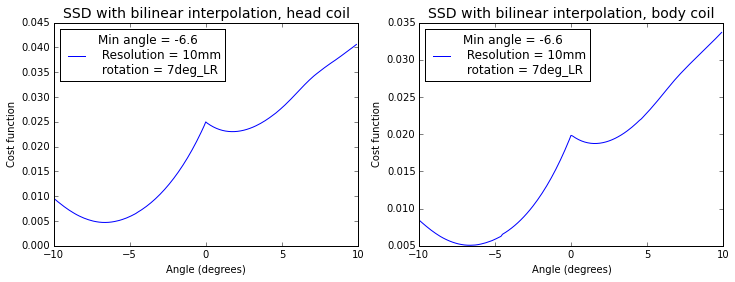

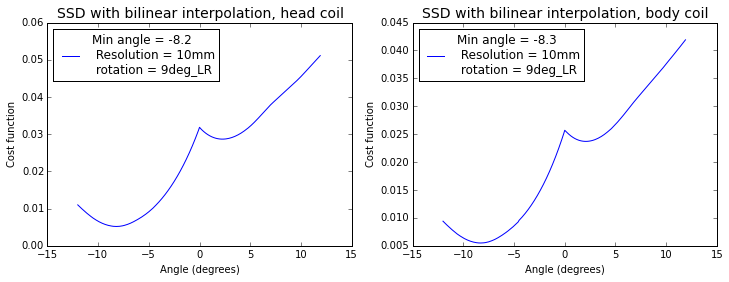

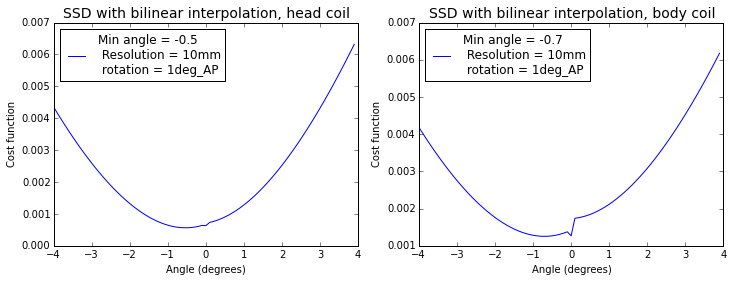

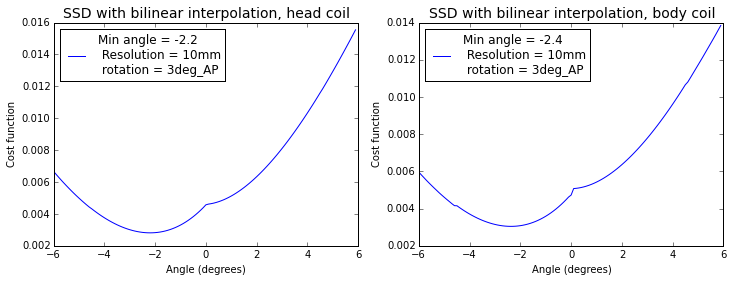

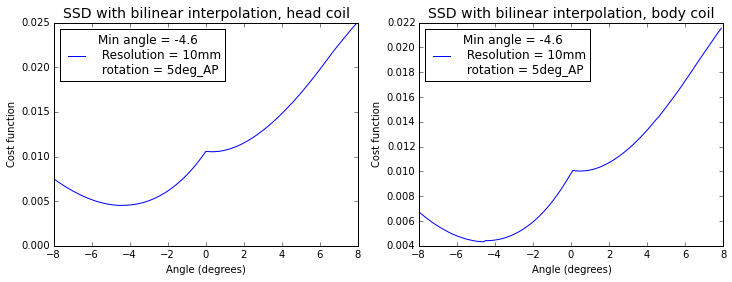

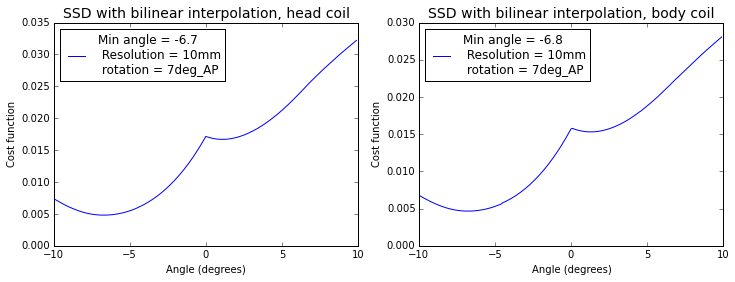

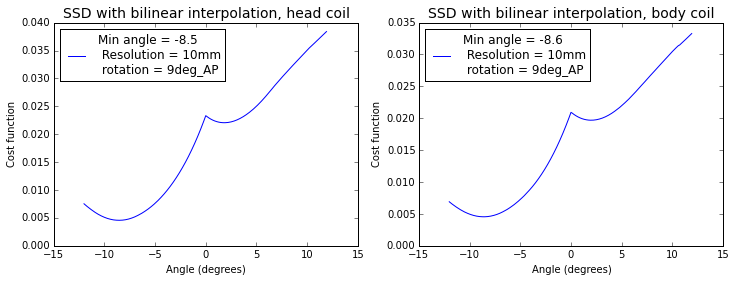

In [57]:
# repetition 2
rot_axes = ['LR','AP']
degrees = ['1deg','3deg','5deg','7deg','9deg']
resolutions = ['5mm','6_4mm','8mm','10mm']
for res in resolutions:
    for rot in rot_axes:
        if(rot == 'LR'): ax = 0
        if(rot == 'AP'): ax = 1
        for deg in degrees:
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                d = int(deg[0])
                thetas = np.arange(-d-3,d+3,0.1)
                cost = rot_cost_func(data_dict[res][coil]['iso'][2],data_dict[res][coil][rot][deg][2],thetas,axis=ax)
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, 'bilinear',deg+'_'+rot, coil)
            plt.show()